West Nile Virus Classification

Project notebook organisation:<br>
**1 - Exploratory Data Analysis and Feature Engineering** (current notebook)<br>
[2 - Model Tuning and Insights](./2_model_tuning_and_insights.ipynb)<br>
<br>
<br>

In [9]:
# import libraries
import pandas as pd, numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from mpl_toolkits import mplot3d
import seaborn as sns

import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geopy.distance import geodesic

import datetime as dt

import shapely
from shapely import geometry
from shapely import ops
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

import featuretools as ft

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline



# Introduction & Problem Statement
---

West Nile virus (WNV) is the leading mosquito-borne disease in the United States ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). It is a single-stranded RNA virus from the family Flaviviridae, which also contains the Zika, dengue, and yellow fever virus. It is primarily transmitted by mosquitoes (mainly <i>Culex</i> spp.), which become infected when they feed on birds, WNV's primary hosts. Infected mosquitos then spread WNV to people and another animals by biting them. Cases of WNV occur during mosquito season, which starts in the summer and continues through fall ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). 

While WNV is not extremely virulent and only about 1 in 5 people who are infected develop West Nile fever and other symptoms, about 1 out of every 150 infected develop a serious and sometimes fatal illness ([CDC, 2009](https://www.cdc.gov/westnile/index.html)). There is currently no vaccine against WNV.

In view of the recent outbreak of WNV in Chicago, the Chicago Department of Public Health (CDPH) has set up a surveillance and control system to trap mosquitos and test for the presence of WNV. The goal of this project is to use these surveillance data to predict the occurrence of WNV given time, location, and mosquito species. Findings from this project will guide and inform decisions on where and when to deploy pesticides throughout the city, to maximise pesticide effectiveness and minimise spending.

# Exploratory Data Analysis
---

In [10]:
trap = pd.read_csv('assets/train.csv', parse_dates=['Date'])
test = pd.read_csv('assets/test.csv', parse_dates=['Date'])
spray = pd.read_csv('assets/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('assets/weather.csv', parse_dates=['Date'])

In [11]:
# getting some basic information about each dataframe
# shape of dataframe i.e. number of rows and columns
# total number of rows with null values
# total number of duplicates
# data types of columns

def basic_eda(df, df_name):
    print(df_name.upper())
    print()
    print(f"Rows: {df.shape[0]} \t Columns: {df.shape[1]}")
    print()
    
    print(f"Total null rows: {df.isnull().sum().sum()}")
    print(f"Percentage null rows: {round(df.isnull().sum().sum() / df.shape[0] * 100, 2)}%")
    print()
    
    print(f"Total duplicate rows: {df[df.duplicated(keep=False)].shape[0]}")
    print(f"Percentage dupe rows: {round(df[df.duplicated(keep=False)].shape[0] / df.shape[0] * 100, 2)}%")
    print()
    
    print(df.dtypes)
    print("-----\n")

In [12]:
dfs = [
    (trap, 'trap'),
    (spray, 'spray'),
    (weather, 'weather'),
    (test, 'test')
    ]

In [13]:
[basic_eda(df, name) for df, name in dfs]

TRAP

Rows: 10506 	 Columns: 12

Total null rows: 0
Percentage null rows: 0.0%

Total duplicate rows: 1062
Percentage dupe rows: 10.11%

Date                      datetime64[ns]
Address                           object
Species                           object
Block                              int64
Street                            object
Trap                              object
AddressNumberAndStreet            object
Latitude                         float64
Longitude                        float64
AddressAccuracy                    int64
NumMosquitos                       int64
WnvPresent                         int64
dtype: object
-----

SPRAY

Rows: 14835 	 Columns: 4

Total null rows: 584
Percentage null rows: 3.94%

Total duplicate rows: 543
Percentage dupe rows: 3.66%

Date         datetime64[ns]
Time                 object
Latitude            float64
Longitude           float64
dtype: object
-----

WEATHER

Rows: 2944 	 Columns: 22

Total null rows: 0
Percentage null rows: 0.0

[None, None, None, None]

## Traps

This dataframe contains information associated with each mosquito trap deployed across the city of Chicago. The location of the traps are described by the block number and street name which have been conveniently mapped into Latitude and Longitude.

In [14]:
print(trap.Date.min())
print(trap.Date.max())
trap.head()

2007-05-29 00:00:00
2013-09-26 00:00:00


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

### Mosquito species

Although all species sampled are carriers of WNV, the presence of WNV was tested positive for <i>Culex restuans</i>, <i>C. pipiens</i>, and <i>C.pipiens/restuans</i>. In addition, these 3 categories made up more than 96% of the sample of the species sampled.

(https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf).

In [15]:
# what species are there
print(f'number of species: {trap["Species"].nunique()}')
trap["Species"].value_counts(normalize=True)

number of species: 7


CULEX PIPIENS/RESTUANS    0.452313
CULEX RESTUANS            0.260803
CULEX PIPIENS             0.256901
CULEX TERRITANS           0.021131
CULEX SALINARIUS          0.008186
CULEX TARSALIS            0.000571
CULEX ERRATICUS           0.000095
Name: Species, dtype: float64

Text(0.5, 1.0, 'total number of samples collected for each species')

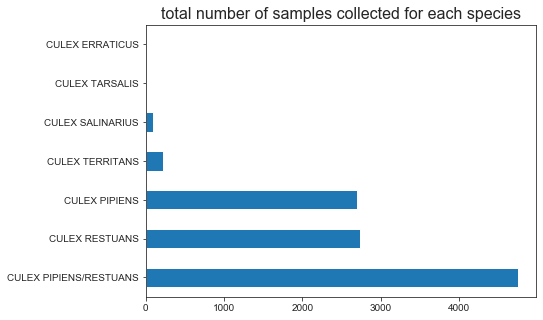

In [16]:
trap['Species'].value_counts().plot(kind='barh', figsize=(7,5))
plt.title('total number of samples collected for each species', fontsize=16)

Species that are tested positive for West Nile Virus.

                        NumMosquitos  WnvPresent
Species                                         
CULEX ERRATICUS                    7           0
CULEX PIPIENS                  44671         240
CULEX PIPIENS/RESTUANS         66268         262
CULEX RESTUANS                 23431          49
CULEX SALINARIUS                 145           0
CULEX TARSALIS                     7           0
CULEX TERRITANS                  510           0


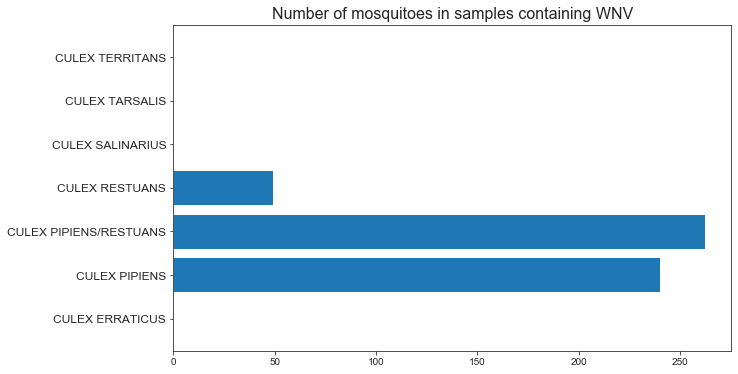

In [17]:
mos_wnv = trap[['Species', 'NumMosquitos', 'WnvPresent']].groupby(by='Species').sum()
print(mos_wnv)
mos_wnv.reset_index(inplace=True)
plt.figure(figsize=(10,6))
plt.barh(mos_wnv['Species'], mos_wnv['WnvPresent'])
plt.title('Number of mosquitoes in samples containing WNV', fontsize=16)
plt.yticks(fontsize=12)
plt.show()

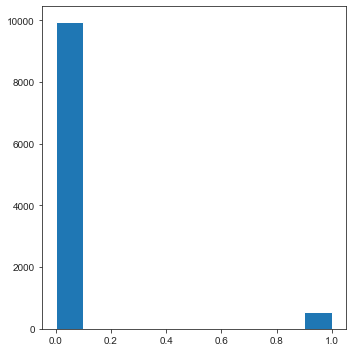

In [18]:
plt.figure(figsize=(5,5))
plt.hist(trap.WnvPresent)
# plt.title('WNV presence by mosquito species', fontsize=16)
# plt.yticks(fontsize=12)
# plt.ylabel('')
# plt.xlabel('Total number of mosquitos',fontsize=14)
plt.tight_layout()

### Add datetime columns

In [19]:
# make datetime columns
trap['Year'] = trap['Date'].apply(lambda x:x.year)
trap['Month'] = trap['Date'].apply(lambda x:x.month)
trap['WeekofYear'] = trap['Date'].apply(lambda x:x.weekofyear)
trap['YearMonth'] = trap['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))

# year 2007 - 2013
print(trap.Year.value_counts().sort_index())

# data only from may - oct
print(trap.Month.value_counts())

# week 22 - 41
print(trap.WeekofYear.value_counts().sort_index())

# total number of weeks in dataset
print(trap.WeekofYear.nunique())

2007    3811
2009    2249
2011    2054
2013    2392
Name: Year, dtype: int64
8     3751
7     2606
9     2218
6     1571
10     276
5       84
Name: Month, dtype: int64
22      84
23     383
24     321
25     332
26     504
27     105
28     981
29     591
30     738
31    1241
32     743
33     804
34     784
35     513
36     431
37     532
38     675
39     468
40     250
41      26
Name: WeekofYear, dtype: int64
20


### Combine mosquito counts

As the test results are organized in a way that the number of mosquitoes are capped at 50 for each record
even when the samples are collected on the same day. We will combine these records into a single record.

In [20]:
trap = trap.groupby([col for col in trap.columns if col not in ['NumMosquitos', \
                                                                'WnvPresent']]).sum()
trap.reset_index(inplace=True)
trap['WnvPresent'] = trap['WnvPresent'].map(lambda x : 1 if x > 0 else x)

trap.head()

Date                                           Address  \
0 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2 2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3 2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4 2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Year  Month  WeekofYear YearMonth  NumMosquitos  WnvPresent  
0  2007      5          22   2007-05             1           0  
1  2007      5          22   2007-05             2           0  
2  2007      5          22   2007-05             1           0  
3  2007      5          22   2007-05             1           0  
4  2007      5          22   2007-05             1           0

### Number of traps and sampling effort

In [21]:
trap['Trap'].nunique()

136

T900     154
T135     147
T002     147
T115     143
T151     143
        ... 
T078       6
T094B      5
T076       5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64


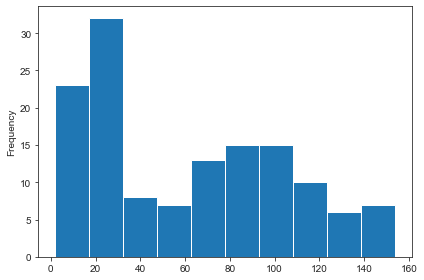

In [22]:
print(trap.Trap.value_counts())
trap.Trap.value_counts().plot(kind='hist')
plt.tight_layout()

- There are 136 traps.
- T900 (at Ohare airport) is sampled the most

### Duplicate addresses for each trap

In [23]:
trap[trap.Trap=='T035'].AddressNumberAndStreet.value_counts()

5100  W 72ND ST, Chicago, IL      45
3000  S HOYNE AVE, Chicago, IL    27
Name: AddressNumberAndStreet, dtype: int64

In [24]:
trap[trap.Trap=='T009'].AddressNumberAndStreet.value_counts()

9100  W HIGGINS RD, Chicago, IL     69
9100  W HIGGINS AVE, Chicago, IL    27
Name: AddressNumberAndStreet, dtype: int64

T035 is probably mislabelled for one of the addresses and T009 is probably a typo. Since coordinates are already present, trap numbers aren't important. Therefore all other location columns such as addresses and `Trap` will be dropped.

### Univariate EDA

#### Distributions

In [25]:
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3], fit = stats.norm)
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

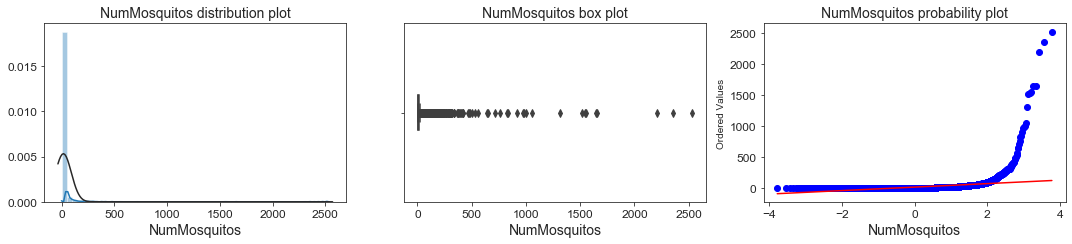

In [26]:
dist_plots(trap, ['NumMosquitos'])

#### Sampling efforts and WNV presence per year

Sampling efforts varied quite a bit between years, with 2007 having the most unique traps being sampled everyday, followed by 2013. This corresponds to the years with the highest WNV presence. This should be taken into consideration when modelling as sampling efforts would affect WNV detectability.

WNV also tends to peak in August.

In [27]:
# get number of unique traps sampled per day
year = trap.groupby(['Year','Date','Latitude','Longitude']).count()[['Species']]
year = year.reset_index()

# total number of unique traps sampled per day, by year
year.Year.value_counts().sort_index()

2007    1459
2009    1006
2011     988
2013    1163
Name: Year, dtype: int64

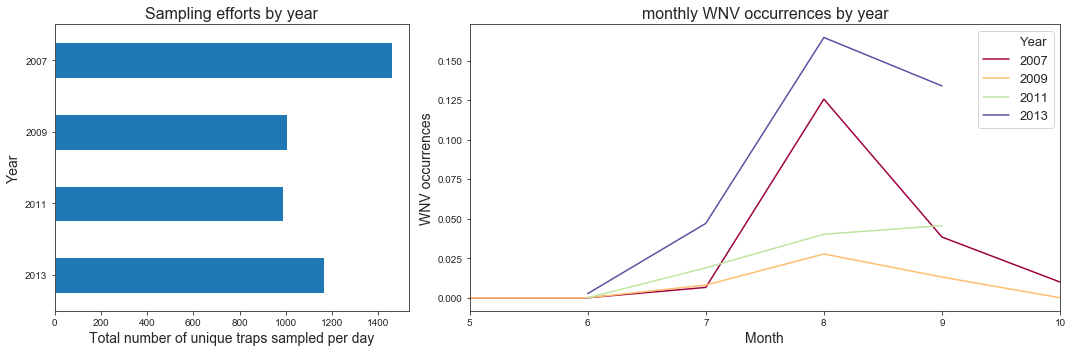

In [28]:
fig, ax = plt.subplots(ncols = 2, figsize=(15,5),  gridspec_kw={'width_ratios': [3, 5]})

# plot sampling efforts by year
year.Year.value_counts().sort_index(ascending=False).plot(kind = 'barh', ax = ax[0])
ax[0].set_title('Sampling efforts by year', fontsize=16)
ax[0].set_ylabel('Year',fontsize=14)
ax[0].set_xlabel('Total number of unique traps sampled per day',fontsize=14)

# plot WNV occurrence by month and year
wnv = trap[['Date','WnvPresent','Year','Month']]
sns.lineplot(x = wnv.Month,y = 'WnvPresent', data = wnv, hue = 'Year', ci = None, 
             legend = 'full', palette = 'Spectral', ax = ax[1])
ax[1].legend(fontsize = 13)
ax[1].set_title('monthly WNV occurrences by year', fontsize=16)
ax[1].set_xlabel('Month',fontsize=14)
ax[1].set_ylabel('WNV occurrences',fontsize=14)
ax[1].set_xlim(wnv.Month.min(), wnv.Month.max())
plt.tight_layout()

#### Number of traps and sampling effort

- There are 136 traps.
- T900 (at Ohare airport) is sampled the most

In [29]:
trap.Trap.nunique()

136

T900     154
T135     147
T002     147
T115     143
T151     143
        ... 
T078       6
T094B      5
T076       5
T237       3
T040       2
Name: Trap, Length: 136, dtype: int64


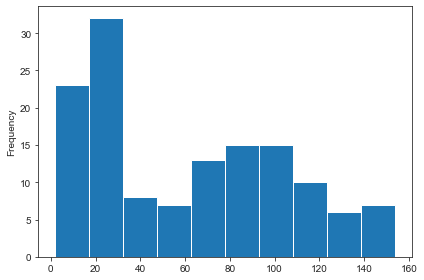

In [30]:
print(trap.Trap.value_counts())
trap.Trap.value_counts().plot(kind='hist')
plt.tight_layout()

In [31]:
trap[trap.Trap=='T900'].head()

Date                                            Address  \
2819 2009-05-28  ORD Terminal 5, O'Hare International Airport, ...   
2921 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
2922 2009-06-03  ORD Terminal 5, O'Hare International Airport, ...   
2989 2009-06-05  ORD Terminal 5, O'Hare International Airport, ...   
2990 2009-06-05  ORD Terminal 5, O'Hare International Airport, ...   

                     Species  Block            Street  Trap  \
2819          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
2921  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
2922          CULEX RESTUANS     10   W OHARE AIRPORT  T900   
2989  CULEX PIPIENS/RESTUANS     10   W OHARE AIRPORT  T900   
2990          CULEX RESTUANS     10   W OHARE AIRPORT  T900   

                  AddressNumberAndStreet   Latitude  Longitude  \
2819  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2921  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2922  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2989  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   
2990  1000  W OHARE AIRPORT, Chicago, IL  41.974689 -87.890615   

      AddressAccuracy  Year  Month  WeekofYear YearMonth  NumMosquitos  \
2819                9  2009      5          22   2009-05            34   
2921                9  2009      6          23   2009-06           254   
2922                9  2009      6          23   2009-06            80   
2989                9  2009      6          23   2009-06            10   
2990                9  2009      6          23   2009-06             2   

      WnvPresent  
2819           0  
2921           0  
2922           0  
2989           0  
2990           0

### Clustering

In [32]:
def dbscan(df, list_of_columns, eps, min_samples):
    
    df_cluster = df[list_of_columns]

    minmax = MinMaxScaler(feature_range = (0, 1))

    clusters = minmax.fit_transform(df_cluster)

    dbs = DBSCAN(eps = eps, min_samples = min_samples)
    dbs.fit(clusters)
    df['Cluster'] = dbs.labels_
    vals = df['Cluster'].value_counts()
    print(f'Silhouette Score: {silhouette_score(clusters, dbs.labels_)}')
    print(f'Number of outliers: {vals[-1]} ({vals[-1] * 100 / len(df):.2f}% of samples)')
    print(f'Number of clusters: {len(vals)}')

    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df['Latitude'], df['Longitude'], df['NumMosquitos'], c = df['Cluster'], cmap = 'rainbow')
    ax.set_title(f'DBSCAN for {list_of_columns}\n\u03B5 = {eps} Min. Clusters = {min_samples}')
    plt.show()
    

In [33]:
trap['Coord'] = [(x, y) for x, y in zip(trap['Latitude'], trap['Longitude'])]

trap_cluster = trap.groupby(['Date', 'Coord']).mean().copy()

Silhouette Score: 0.8026123909766226
Number of outliers: 45 (0.97% of samples)
Number of clusters: 102


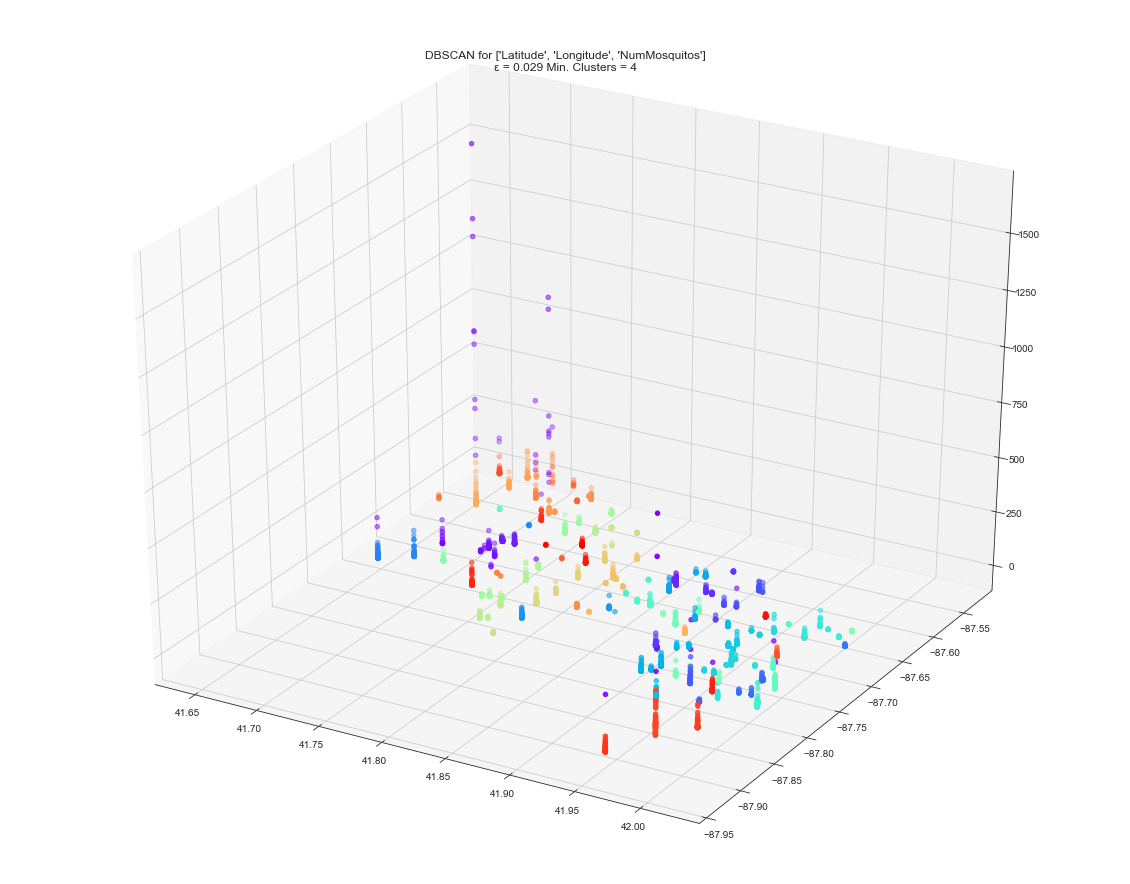

In [34]:
dbscan(trap_cluster, ['Latitude', 'Longitude', 'NumMosquitos'], eps = 0.029, min_samples = 4)

In [35]:
cluster_group_mean = trap_cluster.groupby(['Coord', 'Cluster']).mean()
cluster_group_count = trap_cluster.groupby(['Coord', 'Cluster']).count()

cluster_duplicated = cluster_group_mean.index.get_level_values('Coord').duplicated(keep = False)

cluster_outliers = (cluster_group_mean.index.get_level_values('Cluster') == -1)

#### Checking for LatLongs that belong to more than 1 cluster

In [36]:
# Might actually want to delve into why these specific ones had such cancerous mosquitos
# Seems like 2007 was a terrible year for some places in terms of WNV prevalence

cluster_group_mean.loc[cluster_duplicated, :, :]

Block   Latitude  Longitude  \
Coord                            Cluster                                
(41.659112, -87.53869300000001)  -1        40.0  41.659112 -87.538693   
                                  90       40.0  41.659112 -87.538693   
(41.662014, -87.72460799999999)  -1        42.0  41.662014 -87.724608   
                                  16       42.0  41.662014 -87.724608   
(41.673408, -87.599862)          -1        12.0  41.673408 -87.599862   
                                  76       12.0  41.673408 -87.599862   
(41.702723999999996, -87.536497) -1        11.0  41.702724 -87.536497   
                                  85       11.0  41.702724 -87.536497   
(41.704572, -87.56566600000001)  -1        24.0  41.704572 -87.565666   
                                  82       24.0  41.704572 -87.565666   
(41.726465000000005, -87.585413) -1        10.0  41.726465 -87.585413   
                                  79       10.0  41.726465 -87.585413   
(41.728495, -87.60096300000001)  -1        65.0  41.728495 -87.600963   
                                  94       65.0  41.728495 -87.600963   
(41.798697, -87.736812)          -1        52.0  41.798697 -87.736812   
                                  66       52.0  41.798697 -87.736812   
(41.899229999999996, -87.716788) -1        10.0  41.899230 -87.716788   
                                  46       10.0  41.899230 -87.716788   
(41.9216, -87.666455)            -1        15.0  41.921600 -87.666455   
                                  9        15.0  41.921600 -87.666455   
(41.95469, -87.800991)           -1        41.0  41.954690 -87.800991   
                                  11       41.0  41.954690 -87.800991   
(41.957799, -87.930995)          -1        10.0  41.957799 -87.930995   
                                  93       10.0  41.957799 -87.930995   
(41.973845000000004, -87.805059) -1        51.0  41.973845 -87.805059   
                                  96       51.0  41.973845 -87.805059   
(41.974689, -87.890615)          -1        10.0  41.974689 -87.890615   
                                  91       10.0  41.974689 -87.890615   
(41.991429, -87.747113)          -1        61.0  41.991429 -87.747113   
                                  43       61.0  41.991429 -87.747113   
(42.008314, -87.77792099999999)  -1        70.0  42.008314 -87.777921   
                                  44       70.0  42.008314 -87.777921   

                                          AddressAccuracy         Year  \
Coord                            Cluster                                 
(41.659112, -87.53869300000001)  -1                   8.0  2010.000000   
                                  90                  8.0  2010.416667   
(41.662014, -87.72460799999999)  -1                   8.0  2008.000000   
                                  16                  8.0  2010.031250   
(41.673408, -87.599862)          -1                   5.0  2007.000000   
                                  76                  5.0  2010.535714   
(41.702723999999996, -87.536497) -1                   5.0  2007.000000   
                                  85                  5.0  2007.000000   
(41.704572, -87.56566600000001)  -1                   8.0  2007.000000   
                                  82                  8.0  2010.584906   
(41.726465000000005, -87.585413) -1                   5.0  2007.000000   
                                  79                  5.0  2010.296296   
(41.728495, -87.60096300000001)  -1                   5.0  2013.000000   
                                  94                  5.0  2011.500000   
(41.798697, -87.736812)          -1                   8.0  2011.000000   
                                  66                  8.0  2010.137931   
(41.899229999999996, -87.716788) -1                   9.0  2013.000000   
                                  46                  9.0  2010.000000   
(41.9216, -87.666455)            -1                   8.0  2007.000000   
     

In [37]:
cluster_group_count.loc[cluster_duplicated, :, :]

Block  Latitude  Longitude  \
Coord                            Cluster                               
(41.659112, -87.53869300000001)  -1           2         2          2   
                                  90         48        48         48   
(41.662014, -87.72460799999999)  -1           2         2          2   
                                  16         64        64         64   
(41.673408, -87.599862)          -1          10        10         10   
                                  76         56        56         56   
(41.702723999999996, -87.536497) -1           1         1          1   
                                  85         11        11         11   
(41.704572, -87.56566600000001)  -1           4         4          4   
                                  82         53        53         53   
(41.726465000000005, -87.585413) -1           9         9          9   
                                  79         54        54         54   
(41.728495, -87.60096300000001)  -1           1         1          1   
                                  94         36        36         36   
(41.798697, -87.736812)          -1           1         1          1   
                                  66         58        58         58   
(41.899229999999996, -87.716788) -1           1         1          1   
                                  46         58        58         58   
(41.9216, -87.666455)            -1           1         1          1   
                                  9          15        15         15   
(41.95469, -87.800991)           -1           2         2          2   
                                  11         65        65         65   
(41.957799, -87.930995)          -1           1         1          1   
                                  93         47        47         47   
(41.973845000000004, -87.805059) -1           1         1          1   
                                  96         39        39         39   
(41.974689, -87.890615)          -1           4         4          4   
                                  91         50        50         50   
(41.991429, -87.747113)          -1           1         1          1   
                                  43         56        56         56   
(42.008314, -87.77792099999999)  -1           1         1          1   
                                  44         59        59         59   

                                          AddressAccuracy  Year  Month  \
Coord                            Cluster                                 
(41.659112, -87.53869300000001)  -1                     2     2      2   
                                  90                   48    48     48   
(41.662014, -87.72460799999999)  -1                     2     2      2   
                                  16                   64    64     64   
(41.673408, -87.599862)          -1                    10    10     10   
                                  76                   56    56     56   
(41.702723999999996, -87.536497) -1                     1     1      1   
                                  85                   11    11     11   
(41.704572, -87.56566600000001)  -1                     4     4      4   
                                  82                   53    53     53   
(41.726465000000005, -87.585413) -1                     9     9      9   
                                  79                   54    54     54   
(41.728495, -87.60096300000001)  -1                     1     1      1   
                                  94                   36    36     36   
(41.798697, -87.736812)          -1                     1     1      1   
                                  66                   58    58     58   
(41.899229999999996, -87.716788) -1                     1     1      1   
                                  46                   58    58     58   
(41.9216, -87.666455)            -1                     1     1      1   
                                  9    

#### Check for LatLongs that are clustered all as outliers

In [38]:
cluster_group_mean.loc[(cluster_outliers & (cluster_duplicated == False)), :]

Block   Latitude  Longitude  \
Coord                           Cluster                                
(41.738903, -87.69544300000001) -1        29.0  41.738903 -87.695443   

                                         AddressAccuracy    Year  Month  \
Coord                           Cluster                                   
(41.738903, -87.69544300000001) -1                   8.0  2011.0    9.0   

                                         WeekofYear  NumMosquitos  WnvPresent  
Coord                           Cluster                                        
(41.738903, -87.69544300000001) -1        36.333333           6.0         0.0

In [39]:
cluster_group_count.loc[(cluster_outliers & (cluster_duplicated == False)), :]

Block  Latitude  Longitude  \
Coord                           Cluster                               
(41.738903, -87.69544300000001) -1           3         3          3   

                                         AddressAccuracy  Year  Month  \
Coord                           Cluster                                 
(41.738903, -87.69544300000001) -1                     3     3      3   

                                         WeekofYear  NumMosquitos  WnvPresent  
Coord                           Cluster                                        
(41.738903, -87.69544300000001) -1                3             3           3

#### Cleaning up clusters for mapping

In [40]:
cluster_mapping = cluster_group_mean.reset_index()

# Keeping only one for each of the cluster
# Might not be the best idea, some of these outliers are really because there were some cancerous mosquitos

cluster_mapping = cluster_mapping.drop_duplicates(subset = 'Coord', keep = 'last')

In [41]:
# This is in case any LatLongs still only are clustered all as outliers

cluster_mapping[cluster_mapping['Cluster'] == -1]

Coord  Cluster  Block   Latitude  Longitude  \
34  (41.738903, -87.69544300000001)       -1   29.0  41.738903 -87.695443   

    AddressAccuracy    Year  Month  WeekofYear  NumMosquitos  WnvPresent  
34              8.0  2011.0    9.0   36.333333           6.0         0.0

In [42]:
max(cluster_mapping['Cluster'])

100

In [43]:
cluster_mapping['Cluster'][34] = 101

In [44]:
cluster_dict = dict(zip(cluster_mapping['Coord'], cluster_mapping['Cluster']))

In [45]:
trap['Cluster'] = trap['Coord'].map(cluster_dict)

## Spray

In [46]:
spray = pd.read_csv('assets/spray.csv', parse_dates=['Date'])
print(spray.shape)
spray.head()

(14835, 4)


Date        Time   Latitude  Longitude
0 2011-08-29  6:56:58 PM  42.391623 -88.089163
1 2011-08-29  6:57:08 PM  42.391348 -88.089163
2 2011-08-29  6:57:18 PM  42.391022 -88.089157
3 2011-08-29  6:57:28 PM  42.390637 -88.089158
4 2011-08-29  6:57:38 PM  42.390410 -88.088858

In [47]:
# create another copy of spray to work on
spray1 = spray.copy()

### Handling null values and duplicates

Examine spray dataset for null values

In [48]:
spray1[spray1.isna().any(axis=1)]

Date Time   Latitude  Longitude
1030 2011-09-07  NaN  41.987092 -87.794286
1031 2011-09-07  NaN  41.987620 -87.794382
1032 2011-09-07  NaN  41.988004 -87.794574
1033 2011-09-07  NaN  41.988292 -87.795486
1034 2011-09-07  NaN  41.988100 -87.796014
...         ...  ...        ...        ...
1609 2011-09-07  NaN  41.995876 -87.811615
1610 2011-09-07  NaN  41.995972 -87.810271
1611 2011-09-07  NaN  41.995684 -87.810319
1612 2011-09-07  NaN  41.994724 -87.810415
1613 2011-09-07  NaN  41.993092 -87.810415

[584 rows x 4 columns]

Looks like `Time` is the main source of NaN cells? Let's check if other columns have NaN

In [49]:
spray1.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

We've confirmed that all the null rows were caused by missing data for `Time`. Time data is probably too finely tuned for our needs, so we might drop `Time` from spray instead. 

But first, we want to explore our duplicate spray rows.

In [50]:
# looking at our dupes
spray1[spray1.duplicated(keep=False)].head(20)

Date        Time   Latitude  Longitude
484 2011-09-07  7:43:40 PM  41.983917 -87.793088
485 2011-09-07  7:43:40 PM  41.983917 -87.793088
489 2011-09-07  7:44:32 PM  41.986460 -87.794225
490 2011-09-07  7:44:32 PM  41.986460 -87.794225
491 2011-09-07  7:44:32 PM  41.986460 -87.794225
492 2011-09-07  7:44:32 PM  41.986460 -87.794225
493 2011-09-07  7:44:32 PM  41.986460 -87.794225
494 2011-09-07  7:44:32 PM  41.986460 -87.794225
495 2011-09-07  7:44:32 PM  41.986460 -87.794225
496 2011-09-07  7:44:32 PM  41.986460 -87.794225
497 2011-09-07  7:44:32 PM  41.986460 -87.794225
498 2011-09-07  7:44:32 PM  41.986460 -87.794225
499 2011-09-07  7:44:32 PM  41.986460 -87.794225
500 2011-09-07  7:44:32 PM  41.986460 -87.794225
501 2011-09-07  7:44:32 PM  41.986460 -87.794225
502 2011-09-07  7:44:32 PM  41.986460 -87.794225
503 2011-09-07  7:44:32 PM  41.986460 -87.794225
504 2011-09-07  7:44:32 PM  41.986460 -87.794225
505 2011-09-07  7:44:32 PM  41.986460 -87.794225
506 2011-09-07  7:44:32 PM  41.986460 -87.794225

It's not clear from the data dictonary from Kaggle why there are duplicate records for spray, down to the exact timing. Perhaps multiple rows are meant to indicate the number of times a location was sprayed on one day, to serve as a proxy for total dosage?

In [51]:
# examing one of the records that have a lot of duplicates
spray1.loc[(spray1["Date"] == "2011-09-07") & (spray1["Latitude"]==41.986460) & (spray1["Longitude"]==-87.794225)]

Date        Time  Latitude  Longitude
489  2011-09-07  7:44:32 PM  41.98646 -87.794225
490  2011-09-07  7:44:32 PM  41.98646 -87.794225
491  2011-09-07  7:44:32 PM  41.98646 -87.794225
492  2011-09-07  7:44:32 PM  41.98646 -87.794225
493  2011-09-07  7:44:32 PM  41.98646 -87.794225
...         ...         ...       ...        ...
1025 2011-09-07  7:44:32 PM  41.98646 -87.794225
1026 2011-09-07  7:44:32 PM  41.98646 -87.794225
1027 2011-09-07  7:44:32 PM  41.98646 -87.794225
1028 2011-09-07  7:44:32 PM  41.98646 -87.794225
1029 2011-09-07  7:44:32 PM  41.98646 -87.794225

[541 rows x 4 columns]

With that, we've established that duplicates in spray are purely the result of data collection error, so we can safely drop those rows.

We're going to:
* drop `Time`
* drop duplicate rows

In [52]:
spray1 = spray1.drop(columns=["Time"])
spray1.head()

Date   Latitude  Longitude
0 2011-08-29  42.391623 -88.089163
1 2011-08-29  42.391348 -88.089163
2 2011-08-29  42.391022 -88.089157
3 2011-08-29  42.390637 -88.089158
4 2011-08-29  42.390410 -88.088858

In [53]:
print(f"Spray shape before drop: {spray1.shape}")
spray1 = spray1.drop_duplicates(keep='first')
print(f"New spray shape: {spray1.shape}")

Spray shape before drop: (14835, 3)
New spray shape: (14294, 3)


Now, to find out 
* number of unique spray dates 
* number of sprays made on each unique date

In [54]:
print(spray1["Date"].nunique())
spray1["Date"].value_counts()

10


2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

### Adding geographic and date features

In [55]:
# this function takes in a dataframe and returns a GeoPanda dataframe
# longitude and latitude columns will be formatted into geographic columns
# date columns will be formatted into datetime columns

def gpd_date(df): 
    
    # passing df into a GeoPanda
    
    # creating geometric point
    geom = [Point(xy) for xy in zip(df.Longitude, df.Latitude)]
    # creating a GeoPanda dataframe
    g_df = df.copy()
    g_df = gpd.GeoDataFrame(df, geometry=geom)

    # adding coordinates
    g_df["Coord"] = list(zip(g_df.Latitude, g_df.Longitude))
    
    # formatting `Date` column into a datetime column
    g_df["Date"] = pd.to_datetime(g_df["Date"],format='%Y-%m-%d')
    g_df['Date'] = g_df['Date'].dt.date
    
    # creating a `YearMonth` column for ease of comparison
    g_df['YearMonth'] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    
    # creating a month column
    g_df["Year"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.year)).astype(int)
    
    # creating a month column
    g_df["Month"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.month)).astype(int)
    
    # creating a day column
    g_df["Day"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.day)).astype(int)
    
    # creating a week column
    g_df["Week"] = pd.to_datetime(g_df['Date']).apply(lambda x: '{}'.format(x.week)).astype(int)
    

    return g_df

In [56]:
g_train = gpd_date(trap)
g_train.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Year  Month  WeekofYear YearMonth  NumMosquitos  WnvPresent  \
0  2007      5          22   2007-05             1           0   
1  2007      5          22   2007-05             2           0   
2  2007      5          22   2007-05             1           0   
3  2007      5          22   2007-05             1           0   
4  2007      5          22   2007-05             1           0   

                     Coord  Cluster                    geometry  Day  Week  
0  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22  
1  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22  
2   (41.862292, -87.64886)        4  POINT (-87.64886 41.86229)   29    22  
3  (41.896282, -87.655232)        5  POINT (-87.65523 41.89628)   29    22  
4  (41.907645, -87.760886)        7  POINT (-87.76089 41.90765)   29    22

In [57]:
g_spray = gpd_date(spray1)
g_spray.head()

Date   Latitude  Longitude                    geometry  \
0  2011-08-29  42.391623 -88.089163  POINT (-88.08916 42.39162)   
1  2011-08-29  42.391348 -88.089163  POINT (-88.08916 42.39135)   
2  2011-08-29  42.391022 -88.089157  POINT (-88.08916 42.39102)   
3  2011-08-29  42.390637 -88.089158  POINT (-88.08916 42.39064)   
4  2011-08-29  42.390410 -88.088858  POINT (-88.08886 42.39041)   

                                     Coord YearMonth  Year  Month  Day  Week  
0    (42.3916233333333, -88.0891633333333)   2011-08  2011      8   29    35  
1    (42.3913483333333, -88.0891633333333)   2011-08  2011      8   29    35  
2    (42.3910216666667, -88.0891566666667)   2011-08  2011      8   29    35  
3    (42.3906366666667, -88.0891583333333)   2011-08  2011      8   29    35  
4  (42.390409999999996, -88.0888583333333)   2011-08  2011      8   29    35

### Tracking nearest spray location for each trap record

Using each trap record's date and location, we want to find out if there was any spray activity in recent dates (e.g. within 3 days, within 7 days), then find out the nearest spray location.

In [58]:
# creating a set of unique spray dates
unique_spray_dates = set (g_spray["Date"].unique())
unique_spray_dates

{datetime.date(2011, 8, 29),
 datetime.date(2011, 9, 7),
 datetime.date(2013, 7, 17),
 datetime.date(2013, 7, 25),
 datetime.date(2013, 8, 8),
 datetime.date(2013, 8, 15),
 datetime.date(2013, 8, 16),
 datetime.date(2013, 8, 22),
 datetime.date(2013, 8, 29),
 datetime.date(2013, 9, 5)}

In [59]:
# this function locates the nearest spray site based on recent spray activity
# it takes in `ndays`, then # looks up the spray dataframe to generate an `intersect` set of spray dates  within ndays of the trap record
# as long as a spray date is within ndays of the trap record, the main table will be updated with 
# the location of the nearest spray site and calculates the distance between the trap and that nearest spray site

def nearest_spray(ndays):
    
        ndays_intersect_dates = "n" + str(ndays) + "_" + "intersect_dates"
        ndays_spray_sets = "n" + str(ndays) + "_" + "spray_sets"
        ndays_spray_geom = "n" + str(ndays) + "_" + "spray_geom"
        ndays_spray_coord = "n" + str(ndays) + "_" + "spray_coord"
        ndays_spray_dist_deg = "n" + str(ndays) + "_" + "spray_dist_deg"
        ndays_spray_dist_m = "n" + str(ndays) + "_" + "spray_dist_m"
        
        # this column will store the range of spray dates that were within ndays of a trap record's date 
        g_train[ndays_intersect_dates] = None
        
        # this column will store the gemoetric points of spray sites that were within ndays of a trap record's date 
        g_train[ndays_spray_sets] = None
        
        # this column will store the geometric point of the nearest spray site
        g_train[ndays_spray_geom] = None
        
        # this column will store the coordinates of the nearest spray site
        g_train[ndays_spray_coord] = None
        
        # this column will store the geometric distance between the trap location and the nearest spray site
        g_train[ndays_spray_dist_deg] = None
        
        # this column will store the distance (in metres) between the trap location and the nearest spray site
        g_train[ndays_spray_dist_m] = None
        
        
        n_days = ndays
        
        count = 0

        # populating `ndays_intersect_dates` and `ndays_spray_geom`
        for index, row in g_train.iterrows():

            # date_range contains a range of dates that were within n_days of a trap record's date, including the trap record date
            date_range = set (row["Date"] - dt.timedelta(days=x) for x in range(n_days))
#             print("in date range")
#             print(date_range)

            # intersect contains spray dates that coincide with each trap record's date_range
            intersect = unique_spray_dates.intersection(date_range)
#             print(intersect)
#             print()

            # when interect is not empty
            if len(intersect)!=0:
                
                # passing the set of intersecting dates to `ndays_intersect_dates`
                g_train[ndays_intersect_dates][index]= intersect

                # creating a subset of the spray dataframe using only dates in intersect
                spray_subset = g_spray[g_spray["Date"].isin(intersect)]
                # creating a MultiPoint object using spray_subset
                spray_unary = spray_subset.geometry.unary_union               
                # storing spray_unary 
                g_train[ndays_spray_sets][index] = spray_unary
                
                # finding the point in spray_unary that's nearest to our current trap_point
                trap_point = row.geometry
                queried_geom, nearest_geom = nearest_points(trap_point, spray_unary)
                g_train[ndays_spray_geom][index] = nearest_geom
                
                # storing coordinate of the nearest spray point
                # points are in lon, lat so we need to reverse them
                spray_coord = nearest_geom.y, nearest_geom.x
                g_train[ndays_spray_coord][index] = spray_coord

                # calculating geometric distance between trap point and spray point
                g_train[ndays_spray_dist_deg][index] = g_train[ndays_spray_geom][index].distance(g_train['geometry'][index])
                
                # caclulating distance (in metres) between trap point and spray point
                g_train[ndays_spray_dist_m][index] = geodesic(g_train["Coord"][index], spray_coord).m
                

                count = count+1

            else:
                pass
        
        
        # casting `ndays_spray_dist_deg` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_deg] = g_train[ndays_spray_dist_deg].astype(float)

        
        # casting `ndays_spray_dist_m` into a numeric type so that we can compare correlation with `NumMosquitos` and `WnvPresent`
        g_train[ndays_spray_dist_m] = g_train[ndays_spray_dist_m].astype(float)

        print("Number of rows updated:", count)
        print(f"{ndays_spray_dist_deg} successfully cast to: {g_train[ndays_spray_dist_deg].dtype}")
        print(f"{ndays_spray_dist_m} successfully cast to: {g_train[ndays_spray_dist_m].dtype}")

In [60]:
nearest_spray(3)

Number of rows updated: 938
n3_spray_dist_deg successfully cast to: float64
n3_spray_dist_m successfully cast to: float64


In [61]:
nearest_spray(7)

Number of rows updated: 1159
n7_spray_dist_deg successfully cast to: float64
n7_spray_dist_m successfully cast to: float64


In [62]:
nearest_spray(14)

Number of rows updated: 1543
n14_spray_dist_deg successfully cast to: float64
n14_spray_dist_m successfully cast to: float64


In [63]:
g_train.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Year  Month  WeekofYear YearMonth  NumMosquitos  WnvPresent  \
0  2007      5          22   2007-05             1           0   
1  2007      5          22   2007-05             2           0   
2  2007      5          22   2007-05             1           0   
3  2007      5          22   2007-05             1           0   
4  2007      5          22   2007-05             1           0   

                     Coord  Cluster                    geometry  Day  Week  \
0  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22   
1  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22   
2   (41.862292, -87.64886)        4  POINT (-87.64886 41.86229)   29    22   
3  (41.896282, -87.655232)        5  POINT (-87.65523 41.89628)   29    22   
4  (41.907645, -87.760886)        7  POINT (-87.76089 41.90765)   29    22   

  n3_intersect_dates n3_spray_sets n3_spray_geom n3_spray_coord  \
0               None          None          None           None   
1               None          None          None           None   
2               None          None          None           None   
3               None          None          None           None   
4               None          None          None           None   

   n3_spray_dist_deg  n3_spray_dist_m n7_intersect_dates n7_spray_sets  \
0                NaN              NaN               None          None   
1                NaN              NaN               None          None   
2                NaN              NaN               None          None   
3                NaN              NaN               None          None   
4                NaN              NaN               None          None   

  n7_spray_geom n7_spray_coord  n7_spray_dist_deg  n7_spray_dist_m  \
0          None           None                NaN              NaN   
1          None           None                NaN              NaN   
2          None           None                NaN              NaN   
3          None           None                NaN              NaN   
4          None           None                NaN              NaN   

  n14_intersect_dates n14_spray_sets n14_spray_geom n14_spray_coord  \
0                None           None           None            None   
1                None           None           None            None   
2                None           None           None            None   
3                None           None           None            None   
4                None           None           None            None   

   n14_spray_dist_deg  n14_spray_dist_m  
0                 NaN               NaN  
1                 NaN               NaN  
2                 NaN               NaN  
3                 NaN               NaN  
4                 NaN               NaN

In [64]:
# looking at g_train records where `n14_intersect_dates` are not missing
g_train[g_train.n14_intersect_dates.notnull()]

Date                                            Address  \
5981  2011-09-01      1000 East 67th Street, Chicago, IL 60637, USA   
5982  2011-09-01  1000 North Central Park Avenue, Chicago, IL 60...   
5983  2011-09-01  1000 North Central Park Avenue, Chicago, IL 60...   
5984  2011-09-01        1100 Roosevelt Road, Chicago, IL 60608, USA   
5985  2011-09-01  1100 South California Avenue, Chicago, IL 6061...   
...          ...                                                ...   
8278  2013-09-12           South Vincennes Avenue, Chicago, IL, USA   
8279  2013-09-12           South Vincennes Avenue, Chicago, IL, USA   
8280  2013-09-12  University of Illinois at Chicago, 1100 South ...   
8281  2013-09-12          West Garfield Boulevard, Chicago, IL, USA   
8282  2013-09-12          West Garfield Boulevard, Chicago, IL, USA   

                     Species  Block              Street  Trap  \
5981           CULEX PIPIENS     10           E 67TH ST  T073   
5982  CULEX PIPIENS/RESTUANS     10   N CENTRAL PARK DR  T030   
5983          CULEX RESTUANS     10   N CENTRAL PARK DR  T030   
5984          CULEX RESTUANS     11         W ROOSEVELT  T048   
5985          CULEX RESTUANS     11        S CALIFORNIA  T047   
...                      ...    ...                 ...   ...   
8278           CULEX PIPIENS     10         S VINCENNES  T089   
8279  CULEX PIPIENS/RESTUANS     10         S VINCENNES  T089   
8280           CULEX PIPIENS     11       S ASHLAND AVE  T090   
8281           CULEX PIPIENS     90     W GARFIELD BLVD  T226   
8282  CULEX PIPIENS/RESTUANS     90     W GARFIELD BLVD  T226   

                    AddressNumberAndStreet   Latitude  Longitude  \
5981          1000  E 67TH ST, Chicago, IL  41.773215 -87.600880   
5982  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
5983  1000  N CENTRAL PARK DR, Chicago, IL  41.899230 -87.716788   
5984        1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224   
5985       1100  S CALIFORNIA, Chicago, IL  41.868142 -87.696269   
...                                    ...        ...        ...   
8278        1000  S VINCENNES, Chicago, IL  41.723195 -87.649970   
8279        1000  S VINCENNES, Chicago, IL  41.723195 -87.649970   
8280      1100  S ASHLAND AVE, Chicago, IL  41.868077 -87.666901   
8281    9000  W GARFIELD BLVD, Chicago, IL  41.793818 -87.654234   
8282    9000  W GARFIELD BLVD, Chicago, IL  41.793818 -87.654234   

      AddressAccuracy  Year  Month  WeekofYear YearMonth  NumMosquitos  \
5981                8  2011      9          35   2011-09             1   
5982                9  2011      9          35   2011-09            10   
5983                9  2011      9          35   2011-09             2   
5984                8  2011      9          35   2011-09             1   
5985                9  2011      9          35   2011-09             4   
...               ...   ...    ...         ...       ...           ...   
8278                5  2013      9          37   2013-09             3   
8279                5  2013      9          37   2013-09             8   
8280                9  2013      9          37   2013-09            21   
8281                5  2013      9          37   2013-09             1   
8282                5  2013      9          37   2013-09             7   

      WnvPresent                             Coord  Cluster  \
5981           0            (41.773215, -87.60088)       60   
5982           0  (41.899229999999996, -87.716788)       46   
5983           0  (41.899229999999996, -87.716788)       46   
5984           0           (41.867108, -87.654224)        4   
5985           0           (41.868142, -87.696269)       41   
...          ...                               ...      ...   
8278           0   (41.723195000000004, -87.64997)        3   
8279           0   (41.723195000000004, -87.64997)        3   
8280           1           (41.868077, -87.666901)       21   
8281           0           (41.793818, -87

In [65]:
# checking if we have  g_train records where `n7_intersect_dates` are not missing
g_train[g_train.n7_intersect_dates.notnull()].shape

(1159, 39)

In [66]:
# checking if we have  g_train records where `n3_intersect_dates` are not missing
g_train[g_train.n3_intersect_dates.notnull()].shape

(938, 39)

### Correlation table between `spray_dist`, `NumMosquitos`, and `WnvPresent`

In [67]:
g_train[['n3_spray_dist_deg', 'n7_spray_dist_deg', 'n14_spray_dist_deg', 'NumMosquitos', 'WnvPresent']].corr()

n3_spray_dist_deg  n7_spray_dist_deg  n14_spray_dist_deg  \
n3_spray_dist_deg            1.000000           0.988333            0.602429   
n7_spray_dist_deg            0.988333           1.000000            0.941412   
n14_spray_dist_deg           0.602429           0.941412            1.000000   
NumMosquitos                 0.022472          -0.091472           -0.075735   
WnvPresent                  -0.068348          -0.108154           -0.089598   

                    NumMosquitos  WnvPresent  
n3_spray_dist_deg       0.022472   -0.068348  
n7_spray_dist_deg      -0.091472   -0.108154  
n14_spray_dist_deg     -0.075735   -0.089598  
NumMosquitos            1.000000    0.233532  
WnvPresent              0.233532    1.000000

### Total mosquito count by Year-Month (species combined)

In [68]:
# total number of mosquitoes per month
g_train.groupby(["YearMonth"]).sum()

Block      Latitude      Longitude  AddressAccuracy     Year  \
YearMonth                                                                 
2007-05      906   1046.922110   -2192.404258              198    50175   
2007-06     6763   7330.547616  -15350.505506             1437   351225   
2007-07    18092  19132.355565  -40078.624176             3659   917199   
2007-08    51580  52958.085279 -111002.092980             9986  2540862   
2007-09    25919  27234.459381  -57080.122417             5138  1306557   
2007-10     8113   8410.136978  -17625.274050             1601   403407   
2009-05     2069   2342.271994   -4910.031873              442   112504   
2009-06    16501  19628.484294  -41132.342857             3766   942221   
2009-07    23461  25983.922785  -54460.821289             4916  1247589   
2009-08    11418  13597.873894  -28503.435030             2570   652925   
2009-09    13653  15943.112544  -33413.947905             2988   765429   
2009-10     1986   2635.751286   -5525.645864              493   126567   
2011-06    11801  13141.654908  -27539.557388             2529   631454   
2011-07    19868  22137.496571  -46392.654395             4181  1063819   
2011-08    16954  18743.550122  -39286.625052             3526   900928   
2011-09    18975  20173.080930  -42275.793896             3807   969302   
2013-06    15542  15858.800703  -33237.685413             2995   762927   
2013-07    20164  20461.023215  -42881.962901             3915   984357   
2013-08    29133  29753.936997  -62352.217075             5705  1431243   
2013-09    17198  18119.669089  -37971.585493             3450   871629   

           Month  WeekofYear  NumMosquitos  WnvPresent  Cluster    Day   Week  \
YearMonth                                                                       
2007-05      125         550            40           0      174    725    550   
2007-06     1050        4370           428           0     3622   3428   4370   
2007-07     3199       13059          7199           3    17182   6918  13059   
2007-08    10128       41344         40015         159    55245  16070  41344   
2007-09     5859       24442          9300          25    29593   9816  24442   
2007-10     2010        8060          1706           2     8676    904   8060   
2009-05      280        1232           190           0     2542   1568   1232   
2009-06     2814       11416          7390           0    19472   6322  11416   
2009-07     4347       18241          8833           5    28588  11397  18241   
2009-08     2600       10839          2346           9    15935   5007  10839   
2009-09     3429       14488          2137           5    19019   6356  14488   
2009-10      630        2520           212           0     3412     63   2520   
2011-06     1884        7756          4049           0    15797   6786   7756   
2011-07     3703       15340          8445          10    27527  10539  15340   
2011-08     3584       14523          2968          18    22824   6685  14523   
2011-09     4338       17848          3337          22    24173   7244  17848   
2013-06     2274        9344          4711           1    18927   6981   9344   
2013-07     3423       14080         12771          23    24171   8060  14080   
2013-08     5688       23362         12707         117    34332   9958  23362   
2013-09     3897       16178          6255          58    20930   6417  16178   

           n3_spray_dist_deg  n3_spray_dist_m  n7_spray_dist_deg  \
YearMonth                                                          
2007-05             0.000000     0.000000e+00           0.000000   
2007-06             0.000000     0.000000e+00           0.000000   
2007-07             0.000000     0.000000e+00           0.000000   
2007-08             0.000000     0.000000e+00           0.000000   
2007-09             0.000000     0.000000e+00           0.000000   
2007-10             0.000000     0.000000e+00           0.000000   
2009-05             0.000000     

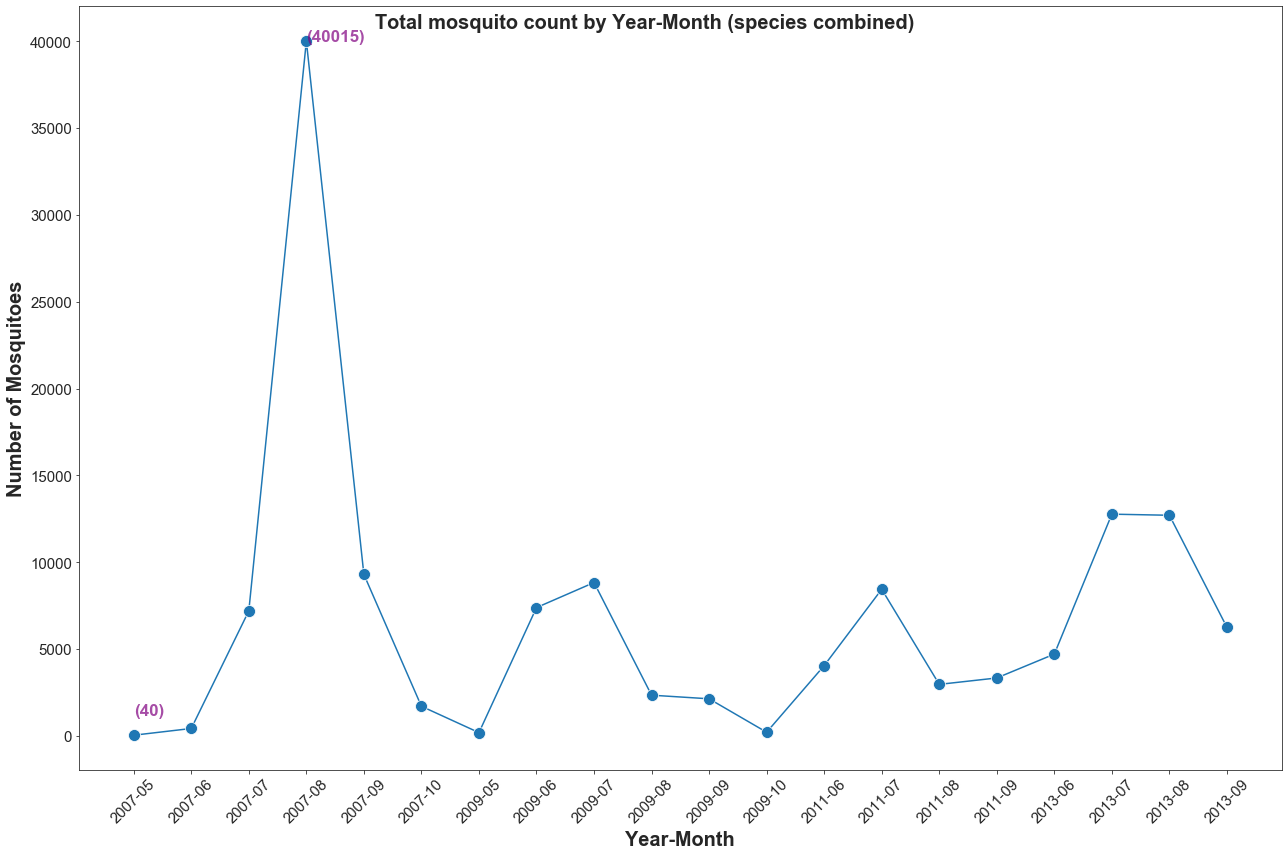

In [69]:
# plotting total number of mosquitos per month

temp_df = g_train.groupby(["YearMonth"]).sum()

plt.figure(figsize=(18,12))

sns.lineplot(x = temp_df.index,y = temp_df['NumMosquitos'], marker='o', markersize=12 )

plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

# to annotate the very first value
first_yearmonth = temp_df.sort_values(by="YearMonth", ascending=True).index[0]
first_val = temp_df.sort_values(by="YearMonth", ascending=True)["NumMosquitos"][0]
plt.text(x = first_yearmonth, y=1200, s="(" + str(first_val) + ")", alpha=0.7, color='purple', fontsize = "17", fontweight="bold")

# to annotate the peak value
max_yearmonth = temp_df.sort_values(by="NumMosquitos", ascending=False).index[0]
max_val = temp_df.sort_values(by="NumMosquitos", ascending=False)["NumMosquitos"][0]
plt.text(x=max_yearmonth, y=max_val, s="(" + str(max_val) + ")", alpha=0.7, color='purple', fontsize = "17", fontweight="bold")

title = "Total mosquito count by Year-Month (species combined)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year-Month (by species)

In [70]:
color_dict = dict({
            'CULEX PIPIENS':'tomato',
            'CULEX PIPIENS/RESTUANS':'orange',
            'CULEX RESTUANS': 'gold',
            'CULEX SALINARIUS': 'wheat',
            'CULEX TERRITANS': 'teal',
            'CULEX TARSALIS' : 'forestgreen',
            'CULEX ERRATICUS': 'dodgerblue'
          })

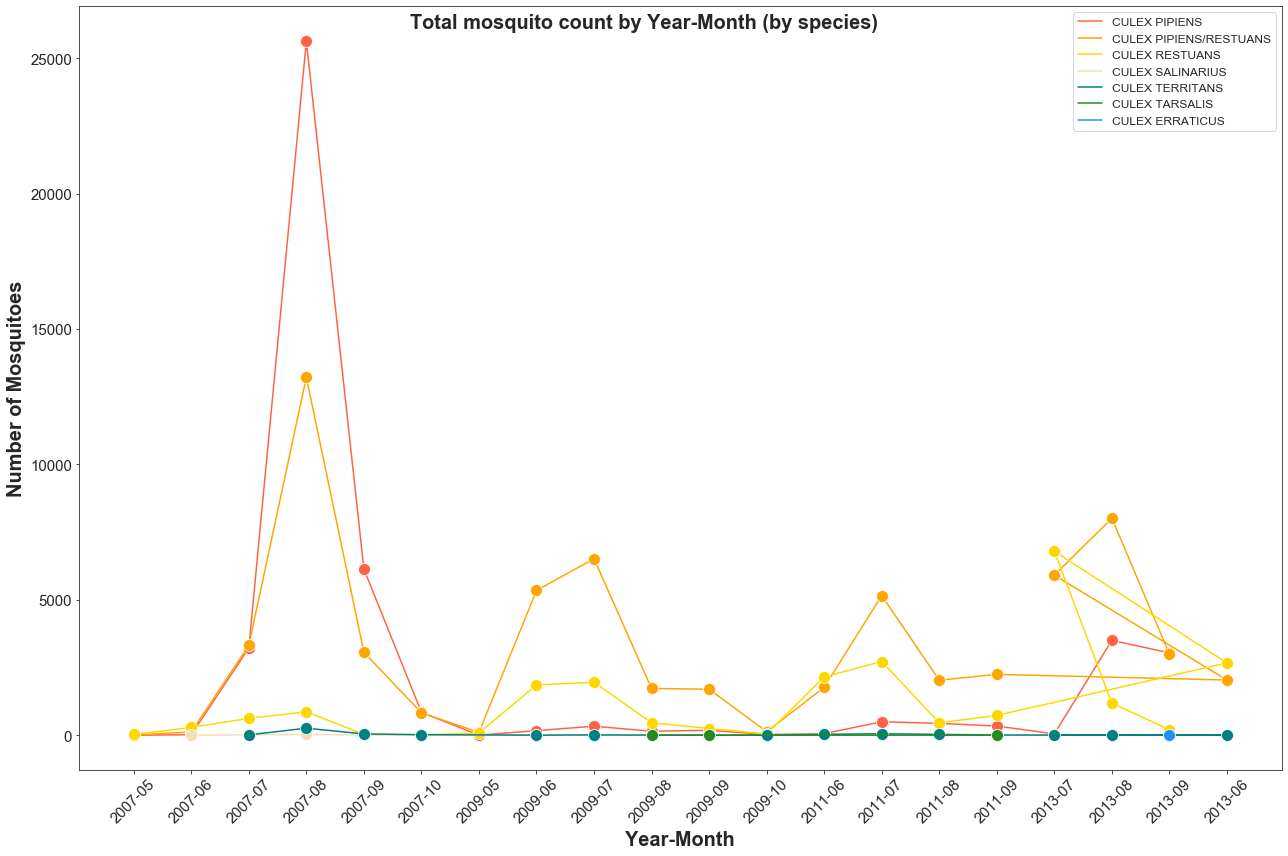

In [71]:
# plotting number of mosquitos per month, segregated by species

# creating a temporary df for our groupby view
temp_df = g_train.groupby(["YearMonth","Species"]).sum()

# since temp_df now is a multi-index df, we need to iterate through the index to pass `YearMonth` and `Species` to the plot  function
x_index = [keys for keys, values in temp_df.index]
hue_index = [values for keys, values in temp_df.index]

plt.figure(figsize=(18,12))

sns.lineplot(x = x_index,y = "NumMosquitos", data =temp_df.sort_index(level=0), marker='o', markersize=12, hue=hue_index, palette=color_dict)


plt.xlabel('Year-Month', fontweight='bold', fontsize='20', horizontalalignment='center')
plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center')

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xticks(rotation=45)

title = "Total mosquito count by Year-Month (by species)"
plt.suptitle(title, fontweight='bold', fontsize='20', horizontalalignment='center')

plt.legend(fontsize='large', title_fontsize='20')


plt.tight_layout()

plt.savefig(title)

### Total mosquito count by Year (by species)

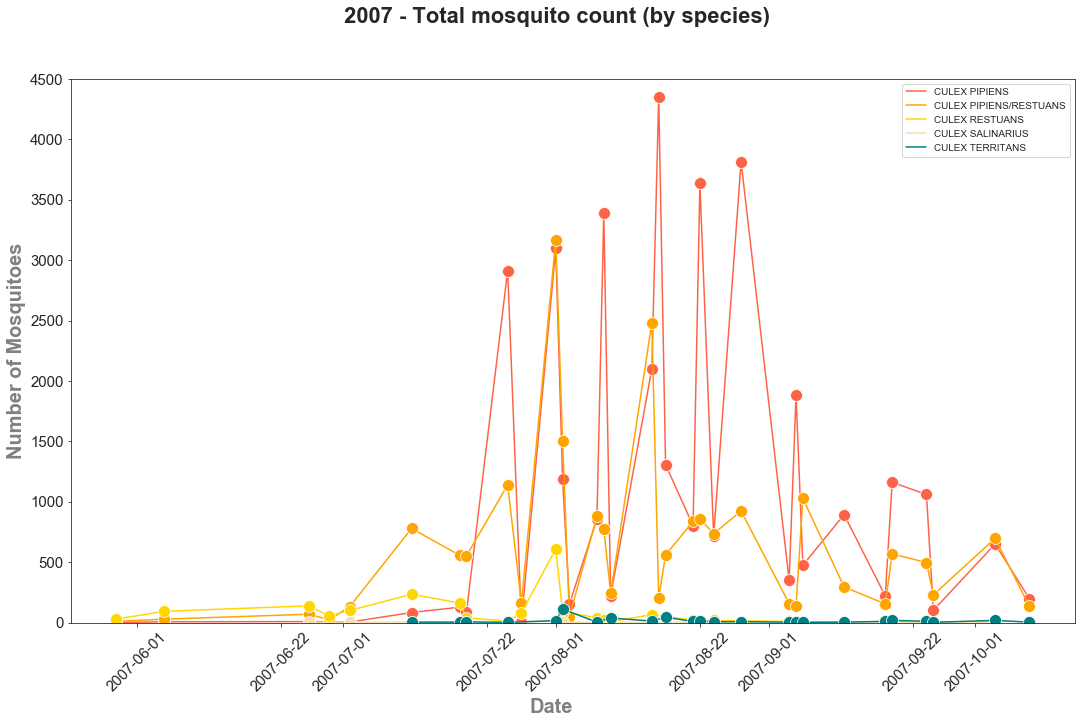

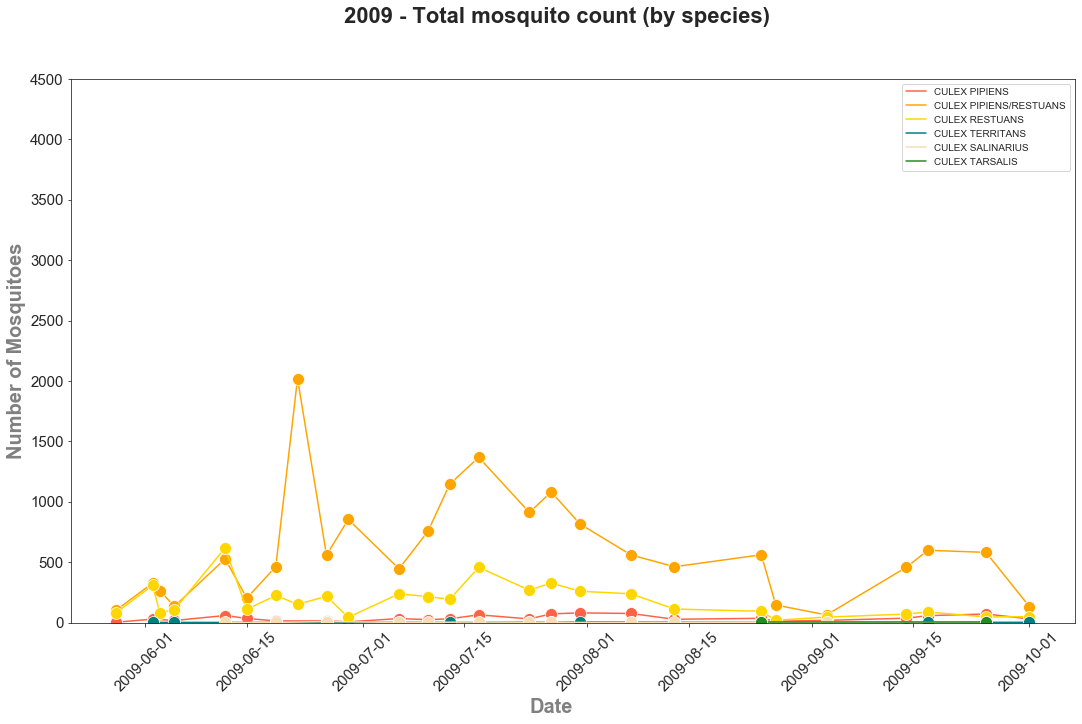

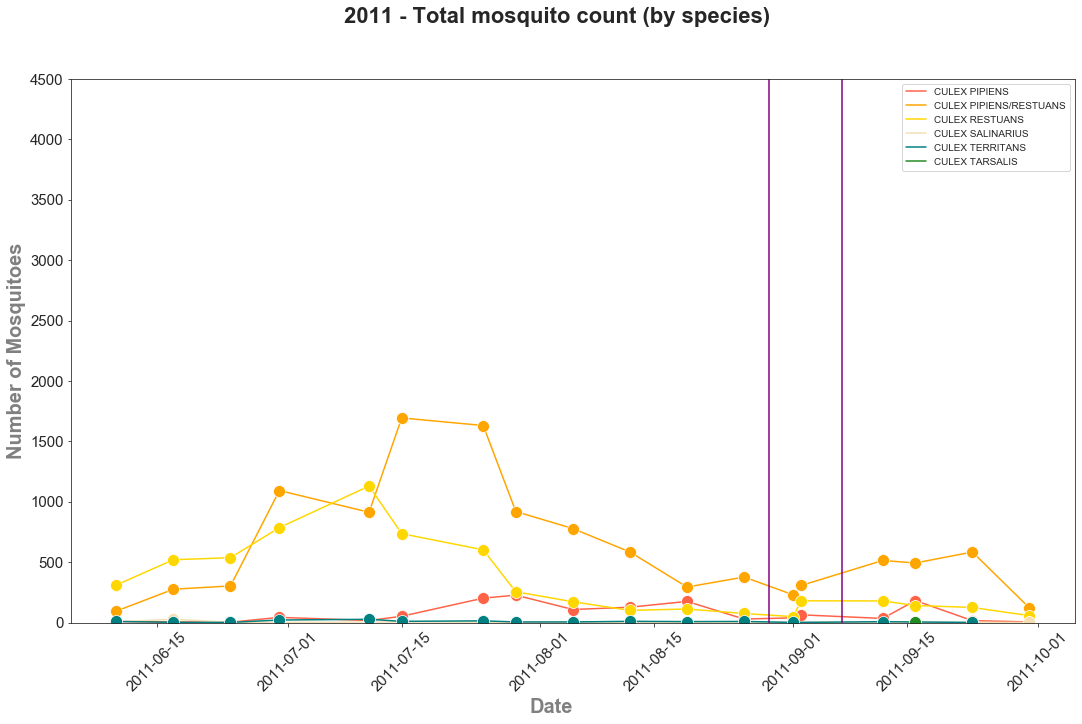

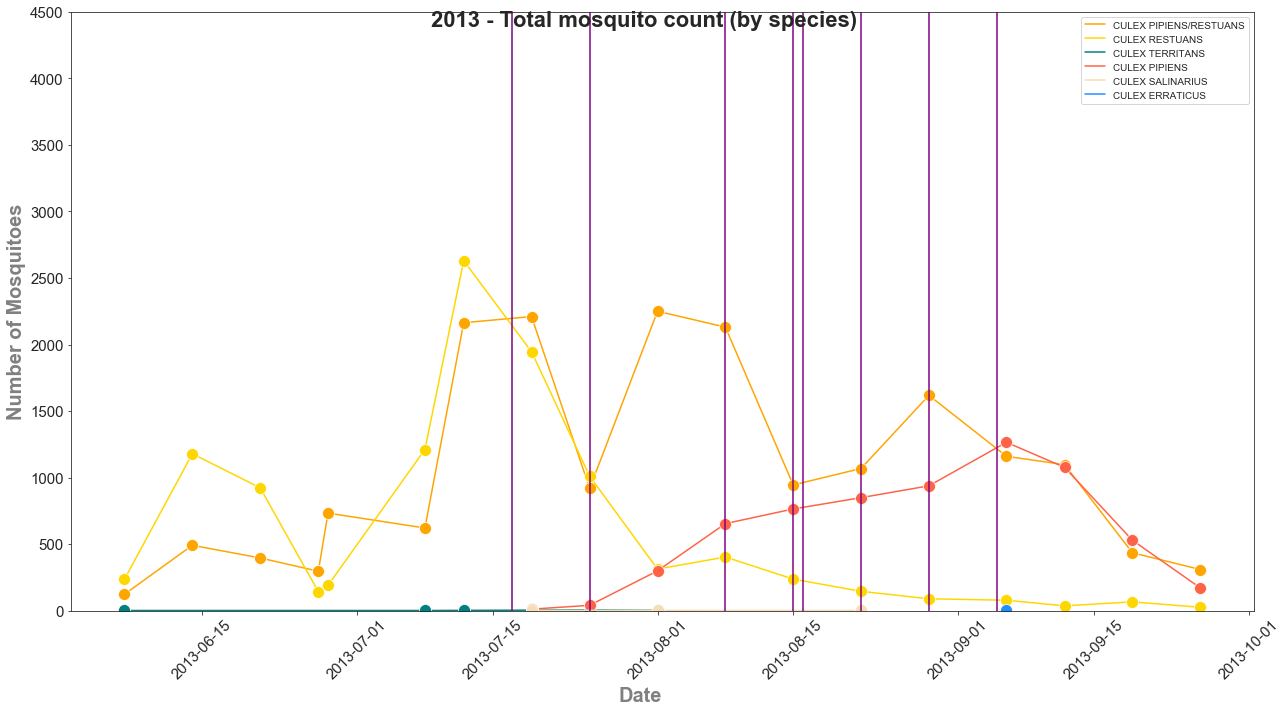

In [72]:
# to show total number of mosquitos per date, segregated by species, with spray dates indicated in purple

for yr in [y for y in g_train['Date'].apply(lambda x: x.year).unique()]:

    # creating a temporary df to show only records for a particular year, grouped by date and species
    temp_df = g_train[g_train["Year"] == yr].groupby(["Date", "Species"]).sum()

    # since temp_df now is a multi-index df, we need to iterate through the index 
    # to pass `Date` and `Species` to the plot  function
    date_index = [keys for keys, values in temp_df.index]
    hue_index = [values for keys, values in temp_df.index]
    
    plt.figure(figsize=(18,10))

    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)

    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    plt.ylim(0, 4500)

    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xticks(rotation=45)
    
    for sp_date in unique_spray_dates:
        if yr == sp_date.year:
            plt.axvline(sp_date, label="spray", color='purple')
#             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
        else:
            pass
    
    title = f"{yr} - Total mosquito count (by species)"
    plt.suptitle(title, fontweight='bold', fontsize='22', horizontalalignment='center')

plt.tight_layout()

### Effect of spraying by date and distance

In [73]:
# this function takes in number of days and spray radius
# then charts total number of mosquitoes (per species) 

# `ndays` refers to the number of days to look up. 
# this only works if nearest_spray() has been called to populate relevant data
# `dist_m` refer to the maximum distance (in metres) that the nearest spray site can be from a trap location 
# for the trap to be considered sprayed
# e.g. if `dist_m` is 100, then this function will only consider traps sprayed
# if the nearest site is no more than 100m away


def spray_effect(ndays, dist_m):
    
    col_name = "n" + str(ndays) + "_spray_dist_m"
    
    if col_name in g_train.columns:
    
        days_df = g_train[g_train[col_name].notnull()]
        
        dist_df = days_df[days_df[col_name] <= dist_m]
        
        if dist_df.shape[0] == 0:
            
            return f"Error: No records returned for `ndays` {ndays} and distance {dist_m}m."
        
        else: 
        
            for yr in [y for y in g_train["Year"].unique()]:
                
                if (yr == 2011) or (yr == 2013):
                    
                    # creating a temporary df to show only records for a particular year, grouped by date and species
                    temp_df = dist_df[dist_df["Year"] == yr].groupby(["Date", "Species"]).sum()

                    # since temp_df now is a multi-index df, we need to iterate through the index 
                    # to pass `Date` and `Species` to the plot  function
                    date_index = [keys for keys, values in temp_df.index]
                    hue_index = [values for keys, values in temp_df.index]

                    plt.figure(figsize=(18,12))

                    sns.lineplot(x = date_index, y = "NumMosquitos", data =temp_df, marker='o', markersize=12, hue=hue_index, palette=color_dict)


                    plt.xlabel('Date', fontweight='bold', fontsize='20', horizontalalignment="right", color="gray")
                    plt.ylabel('Number of Mosquitoes', fontweight='bold', fontsize='20', horizontalalignment='center', color="gray")
    #                 plt.ylim(0, 4500)

                    plt.tick_params(axis='both', which='major', labelsize=15)
                    plt.xticks(rotation=45)


                    for sp_date in unique_spray_dates:
                        if yr == sp_date.year:
                            plt.axvline(sp_date, label="spray", color='purple')
                #             plt.text(x=sp_date, y=1200, s=f'{sp_date}', alpha=0.7, color='purple')
                
        
                        else:
                            pass


                    chart_title = f"{yr} - Total mosquito count (by species)\nrange = {ndays} days, {dist_m}m"
                    plt.suptitle(chart_title, fontweight='bold', fontsize='22', horizontalalignment='center')


                    plt.tight_layout()

                    image_title = f"n{ndays}_{dist_m}m - {yr} - Total moz (by species)"
                    plt.savefig(image_title)
                    
                
                    display(temp_df)
                    
                else:
                    pass

                
    else:
        
        return f"Error: Data for `ndays` = {ndays} not in table"

Block   Latitude  Longitude  \
Date       Species                                               
2011-09-12 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   
2011-09-16 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   

                                   AddressAccuracy  Year  Month  WeekofYear  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS                9  2011      9          37   
           CULEX RESTUANS                        9  2011      9          37   
2011-09-16 CULEX PIPIENS/RESTUANS                9  2011      9          37   
           CULEX RESTUANS                        9  2011      9          37   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2011-09-12 CULEX PIPIENS/RESTUANS             8           0       96   12   
           CULEX RESTUANS                     2           0       96   12   
2011-09-16 CULEX PIPIENS/RESTUANS             9           0       96   16   
           CULEX RESTUANS                     7           0       96   16   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   
2011-09-16 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   

                                   n7_spray_dist_deg  n7_spray_dist_m  \
Date       Species                                                      
2011-09-12 CULEX PIPIENS/RESTUANS           0.000304        26.200614   
           CULEX RESTUANS                   0.000304        26.200614   
2011-09-16 CULEX PIPIENS/RESTUANS           0.000000         0.000000   
           CULEX RESTUANS                   0.000000         0.000000   

                                   n14_spray_dist_deg  n14_spray_dist_m  
Date       Species                                                       
2011-09-12 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614  
2011-09-16 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    186  167.185341 -350.743547   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS    287  251.131886 -526.239503   
           CULEX RESTUANS            186  167.185341 -350.743547   
2013-08-01 CULEX PIPIENS              39   41.951866  -87.725057   
           CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
           CULEX RESTUANS             39   41.951866  -87.725057   
           CULEX TERRITANS            39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    213  209.630981 -438.843066   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             343  334.690935 -701.500075   
           CULEX PIPIENS/RESTUANS    340  376.764191 -789.428596   
           CULEX RESTUANS            216  209.194193 -438.488967   
2013-08-29 CULEX PIPIENS             153  209.091609 -438.198236   
           CULEX PIPIENS/RESTUANS    330  251.187618 -526.034415   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS             196  125.768816 -263.176390   
           CULEX PIPIENS/RESTUANS    196  125.768816 -263.176390   
2013-09-12 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy   Year  Month  WeekofYear  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               31   8052     28         116   
           CULEX RESTUANS                       39  10065     35         145   
2013-07-25 CULEX PIPIENS/RESTUANS               47  12078     42         180   
           CULEX RESTUANS                       31   8052     28         120   
2013-08-01 CULEX PIPIENS                         8   2013      8          31   
           CULEX PIPIENS/RESTUANS                8   2013      8          31   
           CULEX RESTUANS                        8   2013      8          31   
           CULEX TERRITANS                       8   2013      8          31   
2013-08-08 CULEX PIPIENS                         8   2013      8          32   
2013-08-15 CULEX PIPIENS                        17   4026     16          66   
           CULEX PIPIENS/RESTUANS               43  10065     40         165   
           CULEX RESTUANS                        9   2013      8          33   
2013-08-22 CULEX PIPIENS                        59  16104     64         272   
           CULEX PIPIENS/RESTUANS               68  18117     72         306   
           CULEX RESTUANS                       36  10065     40         170   
2013-08-29 CULEX PIPIENS                        33  10065     40         175   
           CULEX PIPIENS/RESTUANS               48  12078     48         210   
           CULEX RESTUANS                       17   4026     16          70   
2013-09-06 CULEX PIPIENS                        25   6039     27         108   
           CULEX PIPIENS/RESTUANS               25   6039     27         108   
2013-09-12 CULEX PIPIENS                         9   2013      9          37   
           CULEX PIPIENS/RESTUANS                9   2013      9          37   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS           190           1       51   76   
           CULEX RESTUANS                   177           0       64   95   
2013-07-25 CULEX PIPIENS/RESTUANS           153           0       92  150   
           CULEX RESTUANS                    97           0       51  100   
2013-08-01 CULEX PI

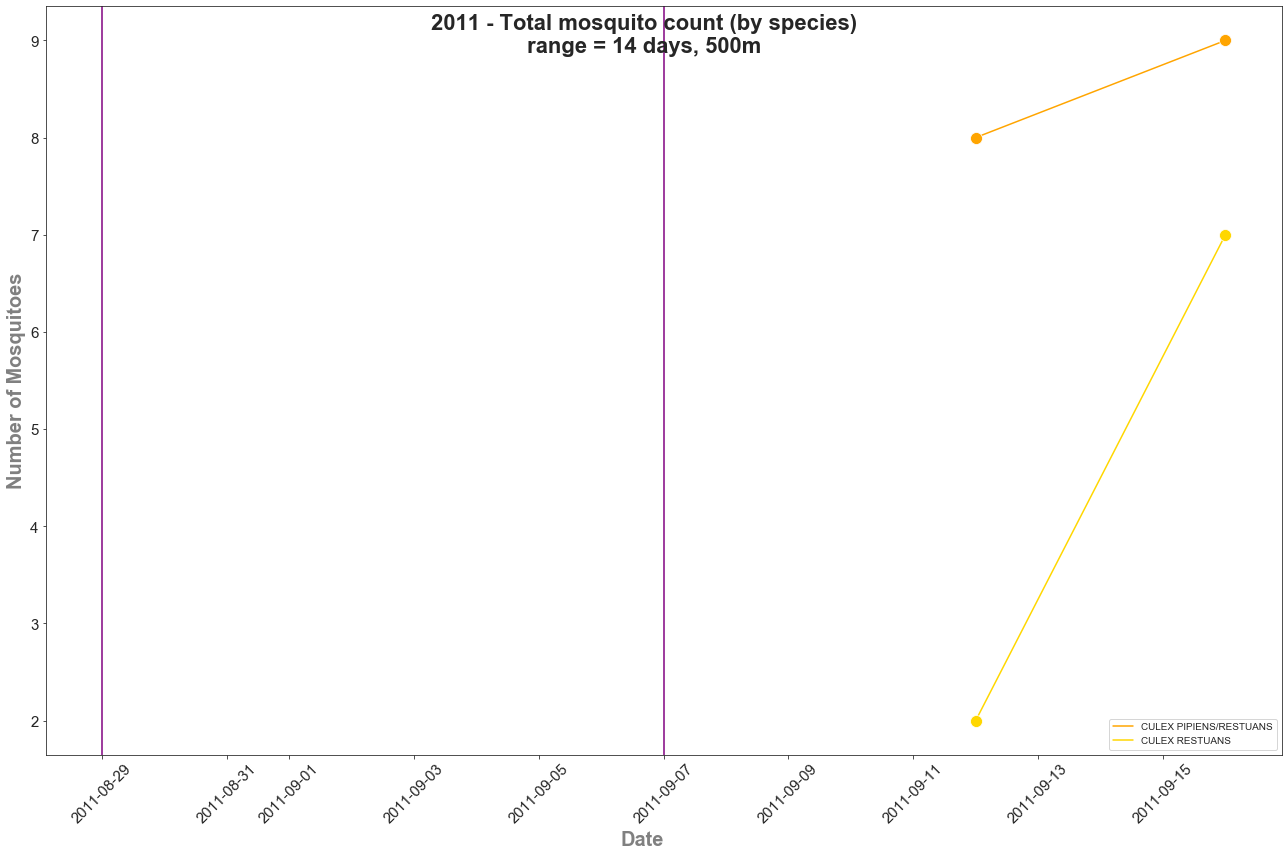

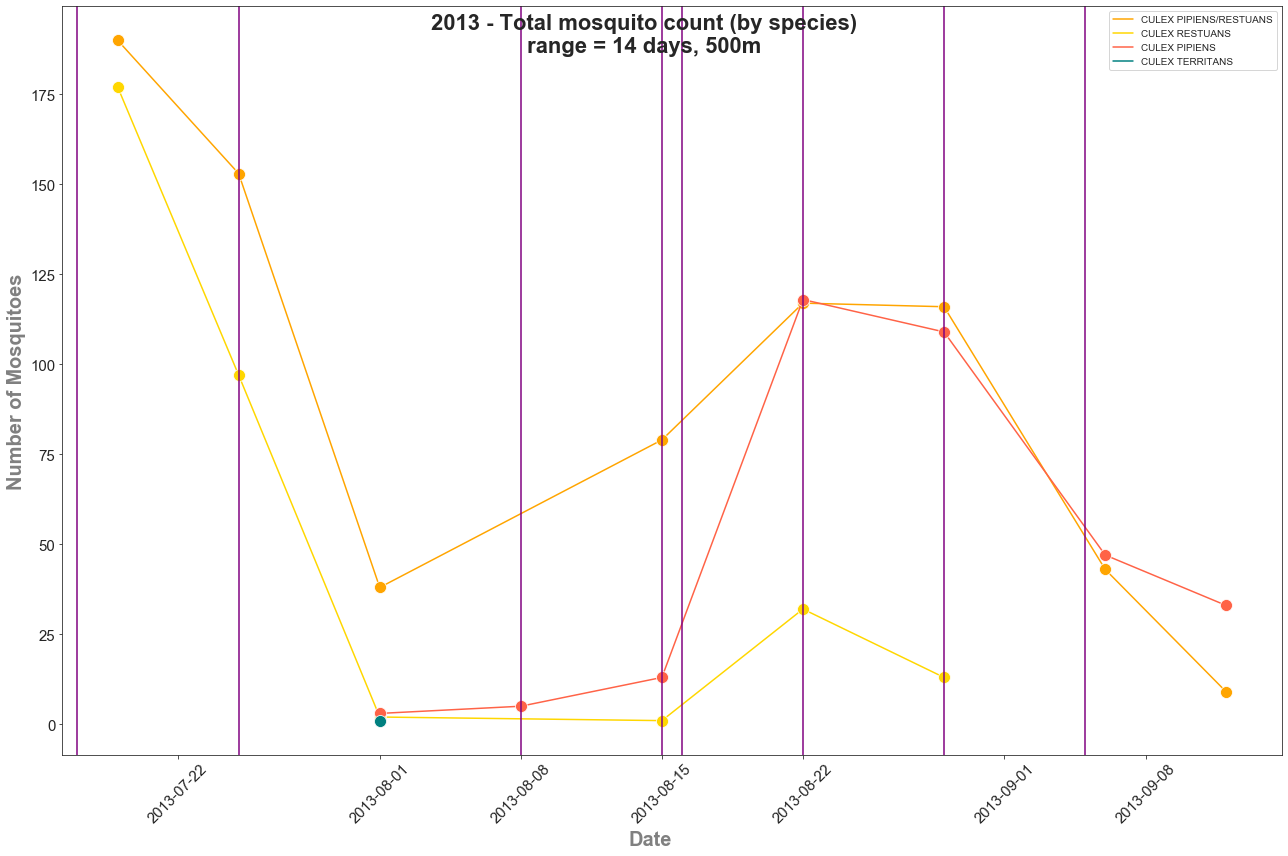

In [74]:
spray_effect(14, 500)

Block   Latitude  Longitude  \
Date       Species                                               
2011-09-12 CULEX PIPIENS/RESTUANS     51  41.973845 -87.805059   
           CULEX RESTUANS             51  41.973845 -87.805059   

                                   AddressAccuracy  Year  Month  WeekofYear  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS                9  2011      9          37   
           CULEX RESTUANS                        9  2011      9          37   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2011-09-12 CULEX PIPIENS/RESTUANS             8           0       96   12   
           CULEX RESTUANS                     2           0       96   12   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2011-09-12 CULEX PIPIENS/RESTUANS    37                0.0              0.0   
           CULEX RESTUANS            37                0.0              0.0   

                                   n7_spray_dist_deg  n7_spray_dist_m  \
Date       Species                                                      
2011-09-12 CULEX PIPIENS/RESTUANS           0.000304        26.200614   
           CULEX RESTUANS                   0.000304        26.200614   

                                   n14_spray_dist_deg  n14_spray_dist_m  
Date       Species                                                       
2011-09-12 CULEX PIPIENS/RESTUANS            0.000304         26.200614  
           CULEX RESTUANS                    0.000304         26.200614

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    186  167.185341 -350.743547   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    185  167.698887 -351.142949   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             232  250.819980 -525.898569   
           CULEX PIPIENS/RESTUANS    155  209.065304 -438.285647   
           CULEX RESTUANS             85  125.354190 -262.903164   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS    183  125.745861 -263.058891   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy   Year  Month  WeekofYear  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               31   8052     28         116   
           CULEX RESTUANS                       39  10065     35         145   
2013-07-25 CULEX PIPIENS/RESTUANS                8   2013      7          30   
2013-08-08 CULEX PIPIENS                         8   2013      8          32   
2013-08-15 CULEX PIPIENS                        17   4026     16          66   
           CULEX PIPIENS/RESTUANS               35   8052     32         132   
           CULEX RESTUANS                        9   2013      8          33   
2013-08-22 CULEX PIPIENS                        42  12078     48         204   
           CULEX PIPIENS/RESTUANS               33  10065     40         170   
           CULEX RESTUANS                       19   6039     24         102   
2013-08-29 CULEX PIPIENS                         9   2013      8          35   
           CULEX PIPIENS/RESTUANS               25   6039     24         105   
           CULEX RESTUANS                       17   4026     16          70   
2013-09-06 CULEX PIPIENS                         9   2013      9          36   
           CULEX PIPIENS/RESTUANS                9   2013      9          36   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS           190           1       51   76   
           CULEX RESTUANS                   177           0       64   95   
2013-07-25 CULEX PIPIENS/RESTUANS            24           0       28   25   
2013-08-08 CULEX PIPIENS                      5           0       26    8   
2013-08-15 CULEX PIPIENS                     13           1       35   30   
           CULEX PIPIENS/RESTUANS            72           2       66   60   
           CULEX RESTUANS                     1           0       11   15   
2013-08-22 CULEX PIPIENS                     96           1      359  132   
           CULEX PIPIENS/RESTUANS            63           1      304  110   
           CULEX RESTUANS                    26           0      219   66   
2013-08-29 CULEX PIPIENS                     17           1       35   29   
           CULEX PIPIENS/RESTUANS            93           1      130   87   
           CULEX RESTUANS                    13           0       71   58   
2013-09-06 CULEX PIPIENS                     18           1       38    6   
           CULEX PIPIENS/RESTUANS            15           1       38    6   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS   116          

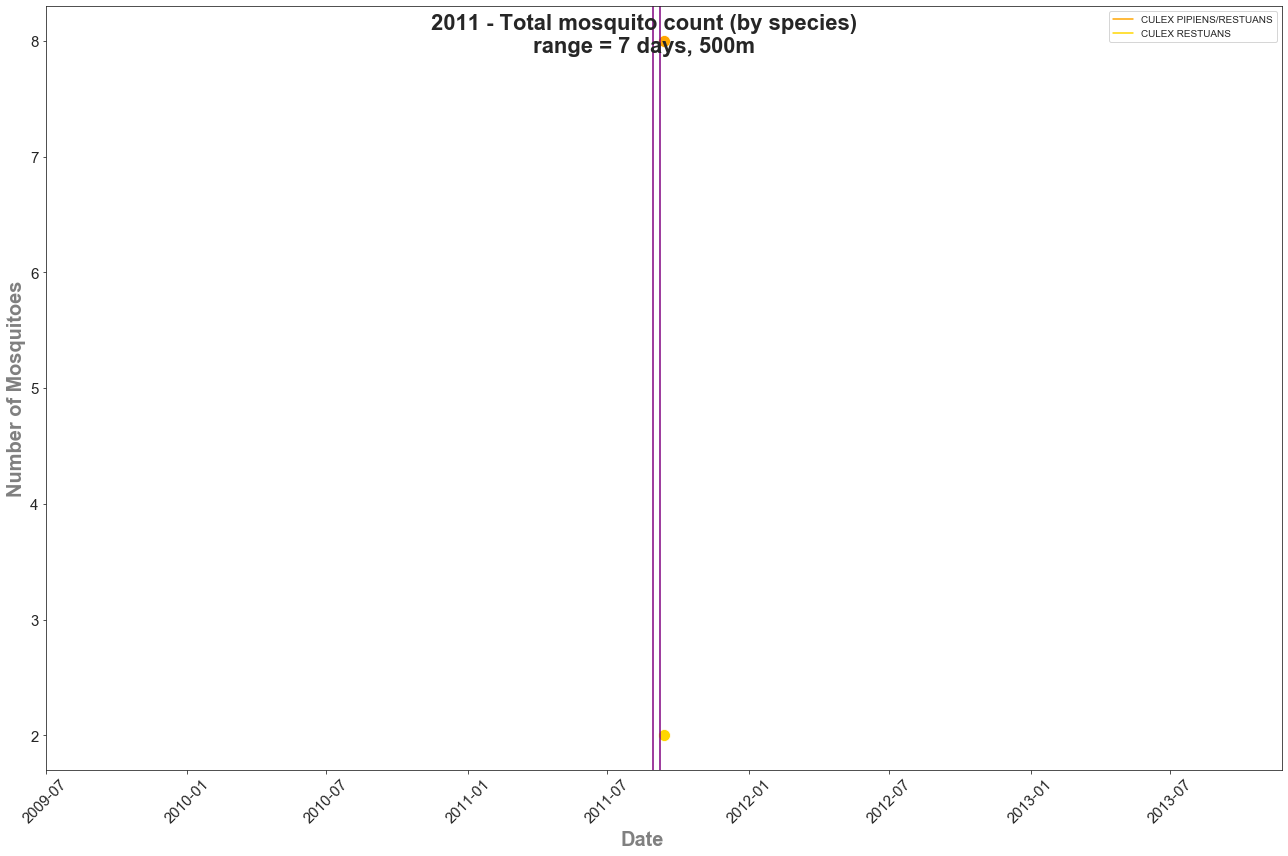

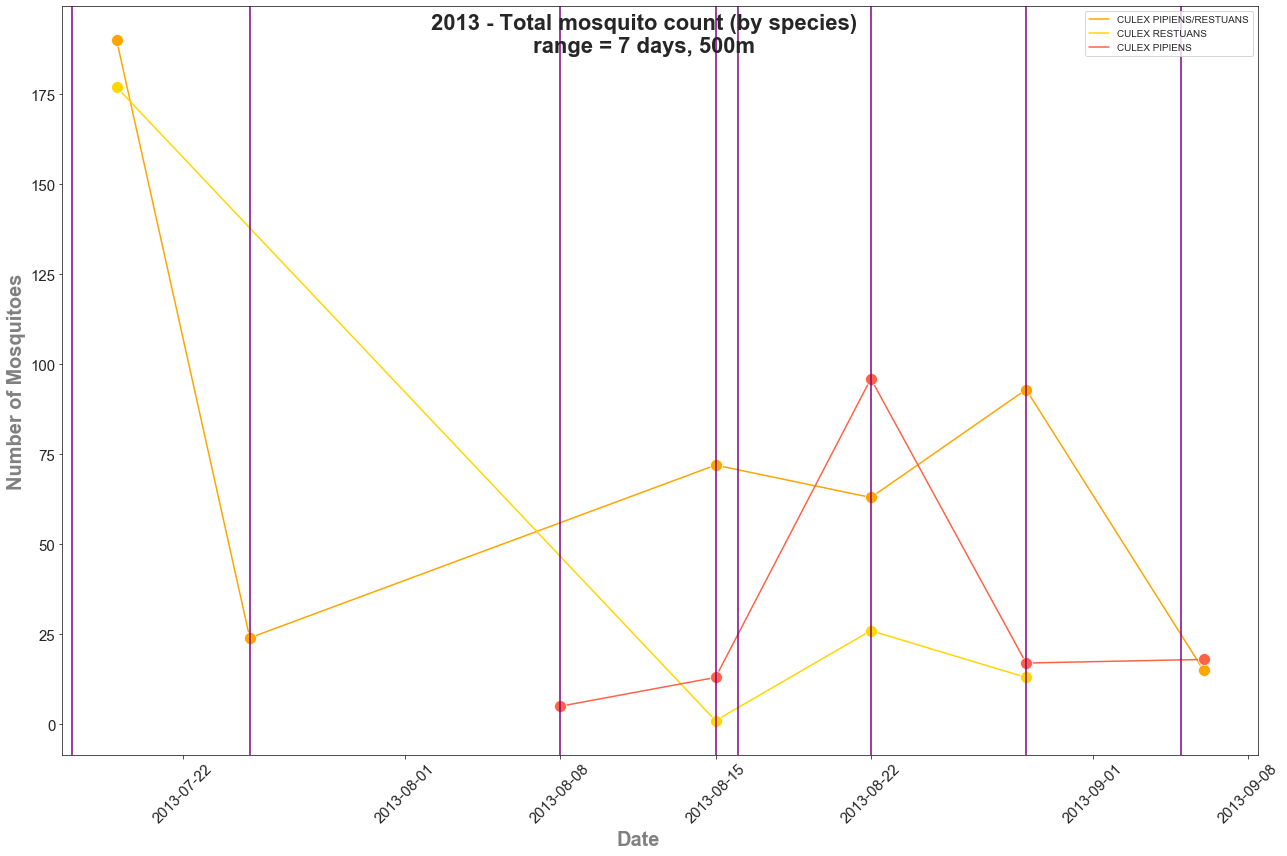

In [75]:
spray_effect(7, 500)

Empty DataFrame
Columns: [Block, Latitude, Longitude, AddressAccuracy, Year, Month, WeekofYear, NumMosquitos, WnvPresent, Cluster, Day, Week, n3_spray_dist_deg, n3_spray_dist_m, n7_spray_dist_deg, n7_spray_dist_m, n14_spray_dist_deg, n14_spray_dist_m]
Index: []

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    186  167.185341 -350.743547   
           CULEX RESTUANS            248  209.180020 -438.514446   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS             111   83.870955 -175.601506   
           CULEX PIPIENS/RESTUANS    185  167.698887 -351.142949   
           CULEX RESTUANS             41   41.954690  -87.800991   
2013-08-22 CULEX PIPIENS             172  208.859364 -438.121380   
           CULEX PIPIENS/RESTUANS     95  167.104688 -350.508458   
           CULEX RESTUANS             85  125.354190 -262.903164   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS    183  125.745861 -263.058891   
           CULEX RESTUANS            116   83.974201 -175.355844   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy   Year  Month  WeekofYear  \
Date       Species                                                             
2013-07-19 CULEX PIPIENS/RESTUANS               31   8052     28         116   
           CULEX RESTUANS                       39  10065     35         145   
2013-07-25 CULEX PIPIENS/RESTUANS                8   2013      7          30   
2013-08-08 CULEX PIPIENS                         8   2013      8          32   
2013-08-15 CULEX PIPIENS                        17   4026     16          66   
           CULEX PIPIENS/RESTUANS               35   8052     32         132   
           CULEX RESTUANS                        9   2013      8          33   
2013-08-22 CULEX PIPIENS                        33  10065     40         170   
           CULEX PIPIENS/RESTUANS               24   8052     32         136   
           CULEX RESTUANS                       19   6039     24         102   
2013-08-29 CULEX PIPIENS                         9   2013      8          35   
           CULEX PIPIENS/RESTUANS               25   6039     24         105   
           CULEX RESTUANS                       17   4026     16          70   
2013-09-06 CULEX PIPIENS                         9   2013      9          36   
           CULEX PIPIENS/RESTUANS                9   2013      9          36   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS           190           1       51   76   
           CULEX RESTUANS                   177           0       64   95   
2013-07-25 CULEX PIPIENS/RESTUANS            24           0       28   25   
2013-08-08 CULEX PIPIENS                      5           0       26    8   
2013-08-15 CULEX PIPIENS                     13           1       35   30   
           CULEX PIPIENS/RESTUANS            72           2       66   60   
           CULEX RESTUANS                     1           0       11   15   
2013-08-22 CULEX PIPIENS                     92           1      329  110   
           CULEX PIPIENS/RESTUANS            58           1      274   88   
           CULEX RESTUANS                    26           0      219   66   
2013-08-29 CULEX PIPIENS                     17           1       35   29   
           CULEX PIPIENS/RESTUANS            93           1      130   87   
           CULEX RESTUANS                    13           0       71   58   
2013-09-06 CULEX PIPIENS                     18           1       38    6   
           CULEX PIPIENS/RESTUANS            15           1       38    6   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS   116          

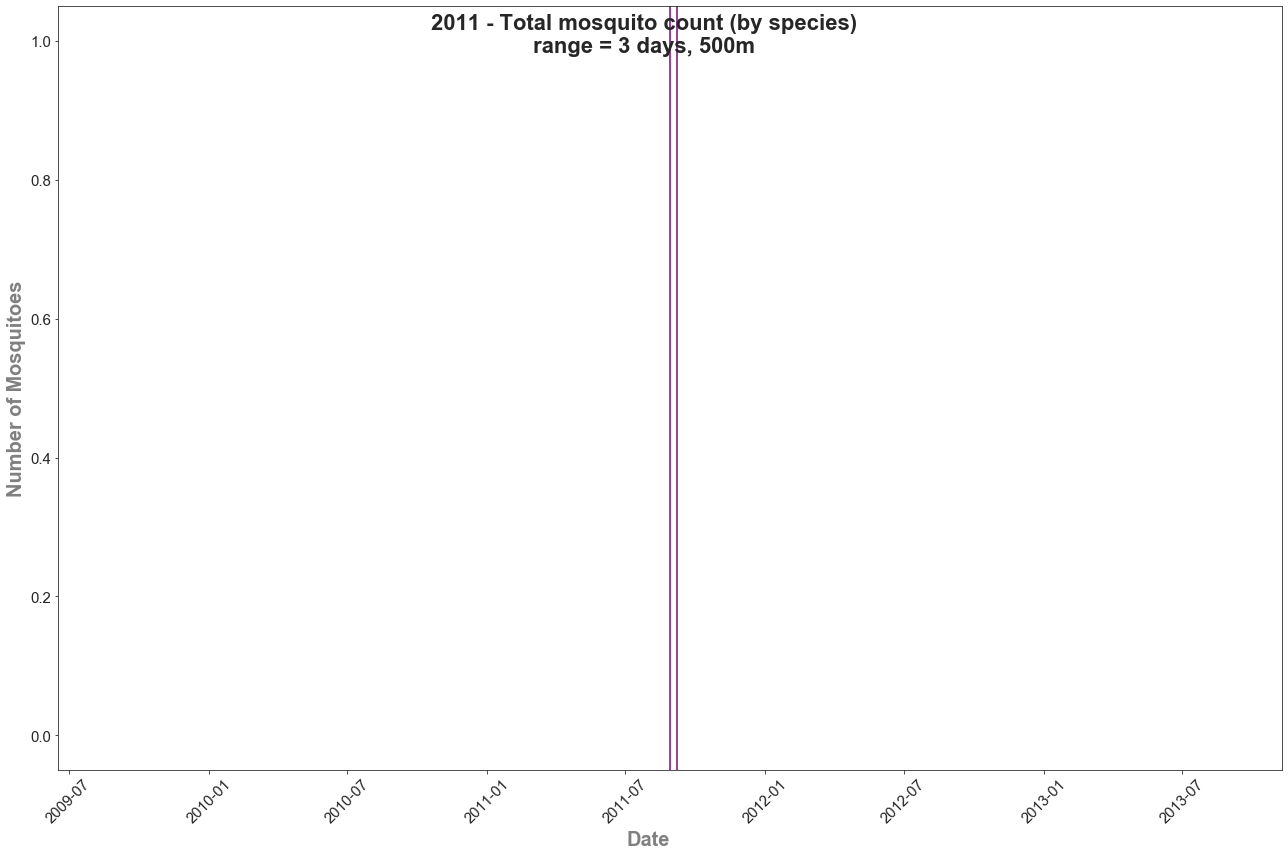

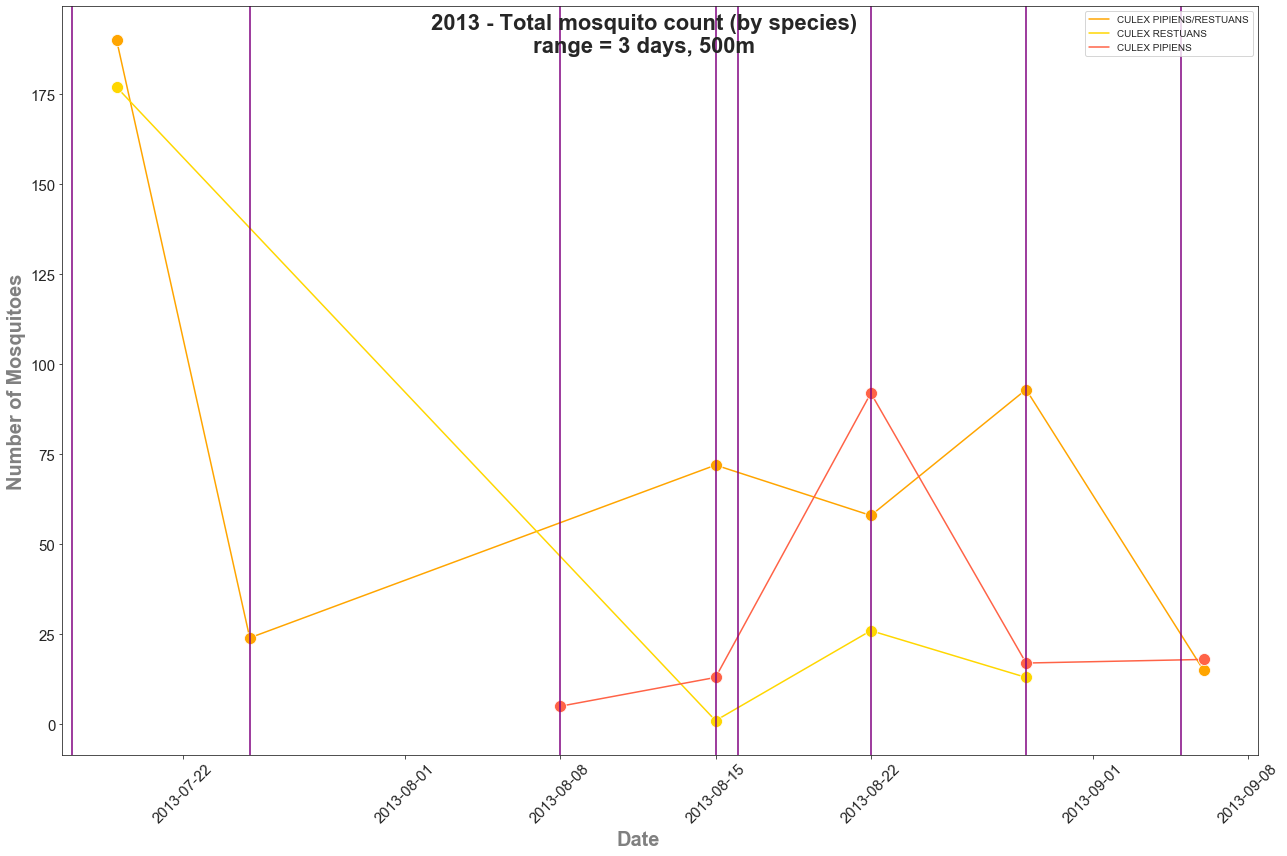

In [76]:
spray_effect(3, 500)

Empty DataFrame
Columns: [Block, Latitude, Longitude, AddressAccuracy, Year, Month, WeekofYear, NumMosquitos, WnvPresent, Cluster, Day, Week, n3_spray_dist_deg, n3_spray_dist_m, n7_spray_dist_deg, n7_spray_dist_m, n14_spray_dist_deg, n14_spray_dist_m]
Index: []

Block    Latitude   Longitude  \
Date       Species                                                 
2013-07-19 CULEX PIPIENS/RESTUANS    169  125.464493 -263.077533   
           CULEX RESTUANS            169  125.464493 -263.077533   
2013-07-25 CULEX PIPIENS/RESTUANS     39   41.951866  -87.725057   
2013-08-08 CULEX PIPIENS              28   41.932094  -87.700117   
2013-08-15 CULEX PIPIENS              70   41.916265  -87.800515   
           CULEX PIPIENS/RESTUANS     83   83.820459 -175.556670   
2013-08-29 CULEX PIPIENS              58   41.986921  -87.689778   
           CULEX PIPIENS/RESTUANS     58   41.986921  -87.689778   
           CULEX RESTUANS             58   41.986921  -87.689778   
2013-09-06 CULEX PIPIENS              71   42.009876  -87.807277   
           CULEX PIPIENS/RESTUANS     71   42.009876  -87.807277   

                                   AddressAccuracy  Year  Month  WeekofYear  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS               22  6039     21          87   
           CULEX RESTUANS                       22  6039     21          87   
2013-07-25 CULEX PIPIENS/RESTUANS                8  2013      7          30   
2013-08-08 CULEX PIPIENS                         8  2013      8          32   
2013-08-15 CULEX PIPIENS                         8  2013      8          33   
           CULEX PIPIENS/RESTUANS               17  4026     16          66   
2013-08-29 CULEX PIPIENS                         9  2013      8          35   
           CULEX PIPIENS/RESTUANS                9  2013      8          35   
           CULEX RESTUANS                        9  2013      8          35   
2013-09-06 CULEX PIPIENS                         9  2013      9          36   
           CULEX PIPIENS/RESTUANS                9  2013      9          36   

                                   NumMosquitos  WnvPresent  Cluster  Day  \
Date       Species                                                          
2013-07-19 CULEX PIPIENS/RESTUANS           174           1       50   57   
           CULEX RESTUANS                   162           0       50   57   
2013-07-25 CULEX PIPIENS/RESTUANS            24           0       28   25   
2013-08-08 CULEX PIPIENS                      5           0       26    8   
2013-08-15 CULEX PIPIENS                      9           1       24   15   
           CULEX PIPIENS/RESTUANS            26           1       31   30   
2013-08-29 CULEX PIPIENS                     17           1       35   29   
           CULEX PIPIENS/RESTUANS             3           0       35   29   
           CULEX RESTUANS                     2           0       35   29   
2013-09-06 CULEX PIPIENS                     18           1       38    6   
           CULEX PIPIENS/RESTUANS            15           1       38    6   

                                   Week  n3_spray_dist_deg  n3_spray_dist_m  \
Date       Species                                                            
2013-07-19 CULEX PIPIENS/RESTUANS    87           0.001511       144.020663   
           CULEX RESTUANS            87           0.001511       144.020663   
2013-07-25 CULEX PIPIENS/RESTUANS    30           0.000037         3.234061   
2013-08-08 CULEX PIPIENS             32           0.000493        53.889275   
2013-08-15 CULEX PIPIENS             33           0.000514        57.033549   
           CULEX PIPIENS/RESTUANS    66           0.000576        63.369325   
2013-08-29 CULEX PIPIENS             35           0.001037        87.513591   
           CULEX PIPIENS/RESTUANS    35           0.001037        87.513591   
           CULEX RESTUANS            35           0.001037        87.513591   
2013-09-06 CULEX PIPIENS             36           0.000499        44.600309   
           CULEX PIPIENS/RESTUANS    36           0.000499        44.600309   

                                   n7_spray_dist_deg  n7_spray_dist_m  \
Date       Species 

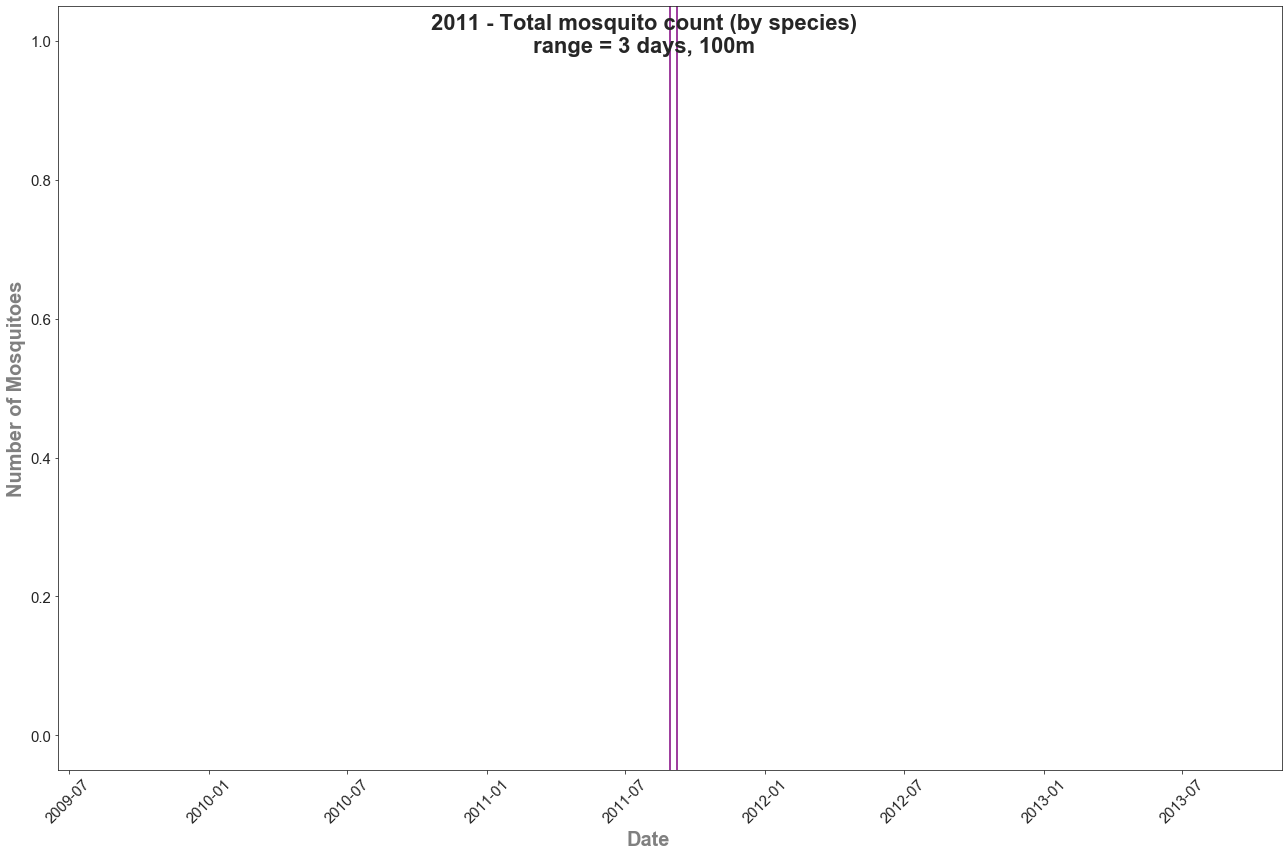

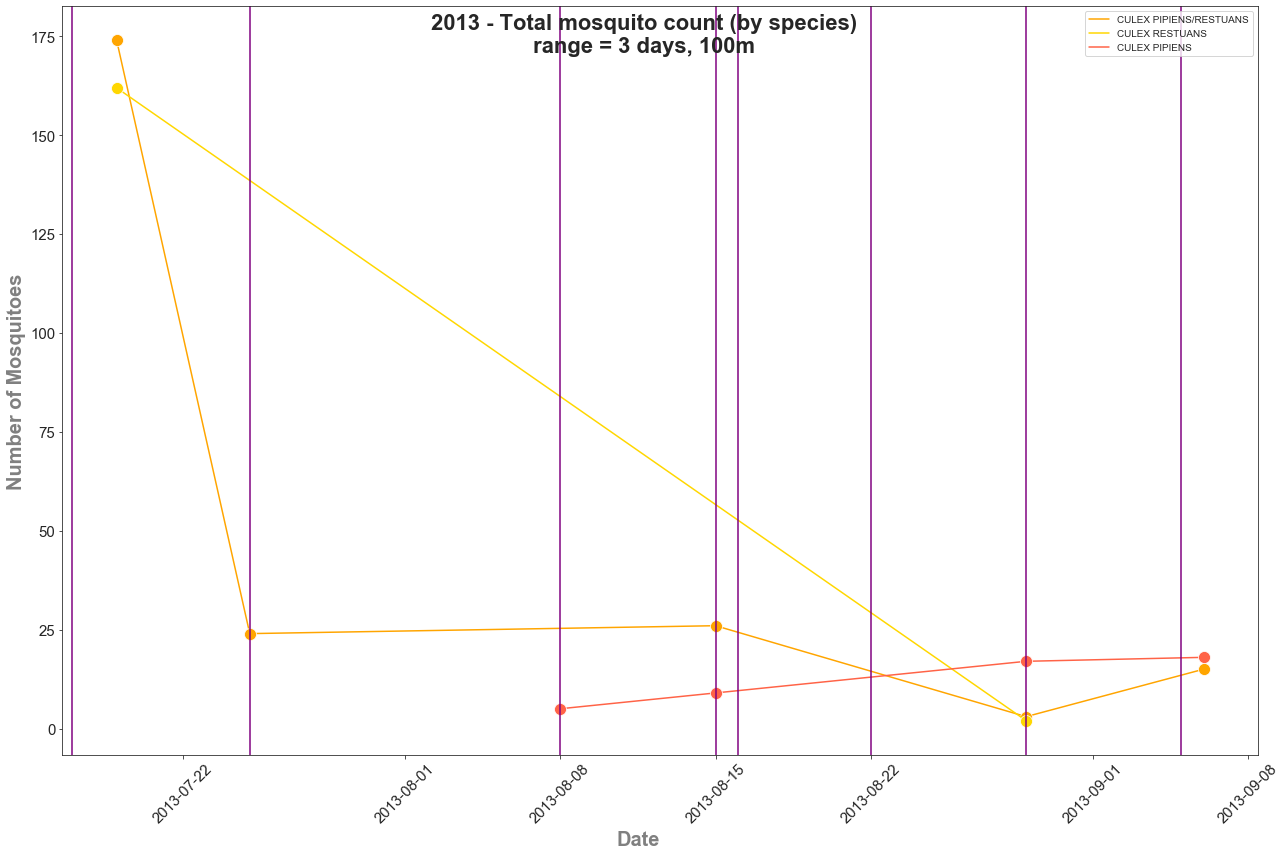

In [77]:
spray_effect(3, 100)

### Conclusion: Relationship between train and spray data

So far we've tried looking at 3-day, 7-day and 14-day ranges with a very generous trap-to-spray distance of 500m. But mosquito count seems to be very erratic. After spraying, sometimes mosquito numbers goes up, and sometimes mosquito numbers go down. This lack of trend suggests that spraying may not have a meaningful impact on mosquito count. 

From research, we know that it takes 10-14 days (weather depending) for mosquito larvae to develop into an adult mosquito. However, since spraying is only useful for killing adult mosquitos, it's not necessary/useful to run this analysis with a date range beyond 14 days.

In addition, given that we only have 10 unique spray dates, there's really not enough data to meaningfully understand the effect of spraying on mosquito population - we cannot determine if this inconclusiveness is because spraying was not effective, or because of issues with the way spraying was carried out. 
From a modeling point of view, the incomplete data makes it difficult to train our model properly. 

Hence, our recommendation - based on the data sets provided - is to turn our attention from spraying to other factors.

## Weather

The weather records provided are between 2007 May and 2014 October. There is a second record everyday as there are 2 weather stations capturing the data each day. From the weather dataset, we are going to focus on variables translating to the optimal condition in the environment for reproduction and they are mainly separated into 2 sections; their habitats and temperature.

Habitat:

Culex mosquitoes breed in various types of stagnant water. Preferred oviposition habitats such as rainwater barrels, catch basins, storm drains, and septic tanks are rich in organic material. Eggs are laid in raft-shaped batches on the water surface.

While Culex will lay their eggs in a variety of standing waters, these habitats can typically be categorized into four ecotypes:

- Sewage Systems
- Container Sources
- Drainage Systems
- Open Habitats

https://www.valentbiosciences.com/publichealth/pests/mosquitoes/mosquitoes-culex/

Temperature:

According to a study conducted on the effects of temperature on the growth and development of Culex pipiens Complex Mosquitoes, it was discovered that varying temperatures were found to have effects on egg embryonation, the lengths of the pupal and larval periods and the survival and longevity of the female mosquitoes.

- In lower temperatures, embryonation took longer among the 20 degree Celsius (68 degree Fahrenheit) and 24 degree Celsius (75.2 degree Fahrenheit) the larval and pupal stages were longer and the female mosquitoes lived longer.
- In higher temperatures, 28 degree Celsius (84.4 degree Fahrenheit), embryonation was faster, the larval and pupal stages were shorter and the females did not live for as long as they did at 20 degree Celsius and 24 degree Celsius.

https://pdfs.semanticscholar.org/1e02/57f23ef925e437a5995c1720b3a2ab518cac.pdf

As such, at first glance, it it likely that the temperature columns "Tmax", "Tmin" and "Tavg" and "PrecipTotal" which indicate the amount of rain will provide the most information on the target.

In [78]:
# date range
weather = pd.read_csv('assets/weather.csv', parse_dates=['Date'])
print(weather['Date'].max())
print(weather['Date'].min())

weather.head()

2014-10-31 00:00:00
2007-05-01 00:00:00


Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50   67     14        51      56    0    2   
1        2 2007-05-01    84    52   68      M        51      57    0    3   
2        1 2007-05-02    59    42   51     -3        42      47   14    0   
3        2 2007-05-02    60    43   52      M        42      47   13    0   
4        1 2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   
3       -      -   BR HZ     M      M        M        0.00       29.44   
4    0446   1851             0      M      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

Traditional techniques will not be able to identify null values as they are being translated into 'M' (according to the data dictionary).

In [79]:
# no nulls but nulls are represented by values like M and -
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

### Add dates

Based on the "Date" column, we will create new columns indicating the "year", "month" and the "weekofyear" columns to streamline our EDA. It is important as the data represented only a certain time period within each year;

- year -> 2007 - 2014
- month -> may - oct (corresponding to when traps are deployed)
- weekofyear -> 17 - 44

In [80]:
weather['Year'] = weather['Date'].apply(lambda x:x.year)
weather['Month'] = weather['Date'].apply(lambda x:x.month)
weather['WeekofYear'] = weather['Date'].apply(lambda x:x.weekofyear)

# view summary of unique values
print(weather.Year.value_counts().sort_index())
print(weather.Month.value_counts())
print(weather.WeekofYear.value_counts().sort_index())

2007    368
2008    368
2009    368
2010    368
2011    368
2012    368
2013    368
2014    368
Name: Year, dtype: int64
7     496
5     496
10    496
8     496
9     480
6     480
Name: Month, dtype: int64
17      6
18     84
19    112
20    112
21    112
22    112
23    112
24    112
25    112
26    112
27    112
28    112
29    112
30    112
31    112
32    112
33    112
34    112
35    112
36    112
37    112
38    112
39    112
40    112
41    112
42    112
43    112
44     54
Name: WeekofYear, dtype: int64


### Fill missing values

In [81]:
# replace trace and missing precip with 0s
weather.PrecipTotal.replace(['  T','M'],0,inplace=True)
weather.PrecipTotal = weather.PrecipTotal.astype(float)

# check number of rows with missing avg temp
print(weather.Tavg.value_counts()['M'])

# imputing Tavg manually (increases accuracy)
weather.Tavg = (weather.Tmax + weather.Tmin)/2
weather.Tavg = weather.Tavg.astype(float)


11


In [82]:
weather[weather.StnPressure=='M']

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68  77.0      M        53      62    0   12   
848         1 2009-06-26    86    69  77.5      7        60       M    0   13   
2410        1 2013-08-10    81    64  72.5      0        57       M    0    8   
2411        2 2013-08-10    81    68  74.5      M        55      63    0   10   

     Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal StnPressure  \
87         -      -             M      M        M          0.0           M   
848     0418   1931             0      M      0.0          0.0           M   
2410    0454   1900             0      M      0.0          0.0           M   
2411       -      -             M      M        M          0.0           M   

     SeaLevel  ResultSpeed  ResultDir AvgSpeed  Year  Month  WeekofYear  
87          M          7.0          5        M  2007      6          24  
848     29.85          6.4          4      8.2  2009      6          26  
2410    30.08          5.3          5      6.5  2013      8          32  
2411    30.07          6.0          6      7.4  2013      8          32

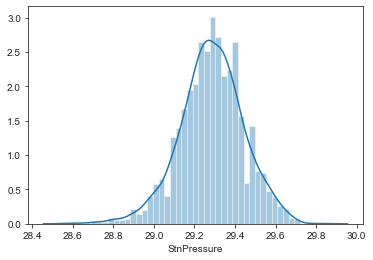

In [83]:
sns.distplot(weather.loc[(weather.StnPressure != 'M'), 'StnPressure'].map(lambda x : float(x)))

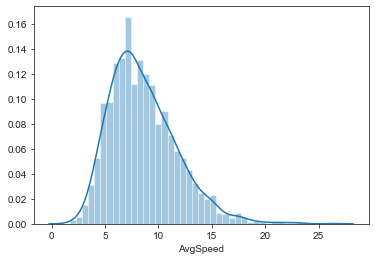

In [84]:
sns.distplot(weather.loc[(weather.AvgSpeed != 'M'), 'AvgSpeed'].map(lambda x : float(x)))

In [85]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')


weather.StnPressure = weather.StnPressure.map(lambda x : np.nan if x == 'M' else x)
weather.AvgSpeed = weather.AvgSpeed.map(lambda x : np.nan if x == 'M' else x)

weather.StnPressure = imp_mean.fit_transform(weather.StnPressure.values.reshape(-1, 1))
weather.AvgSpeed = imp_mean.fit_transform(weather.AvgSpeed.values.reshape(-1, 1))


### Differences between Weather Station 1 and Weather Station 2

Since there are 2 weather stations capturing the weather statistics each day, we will explore the differences in the data captured for each station, mainly focusing on the columns "Tavg" and "PrecipTotal" which are likely to provide more information on our target.

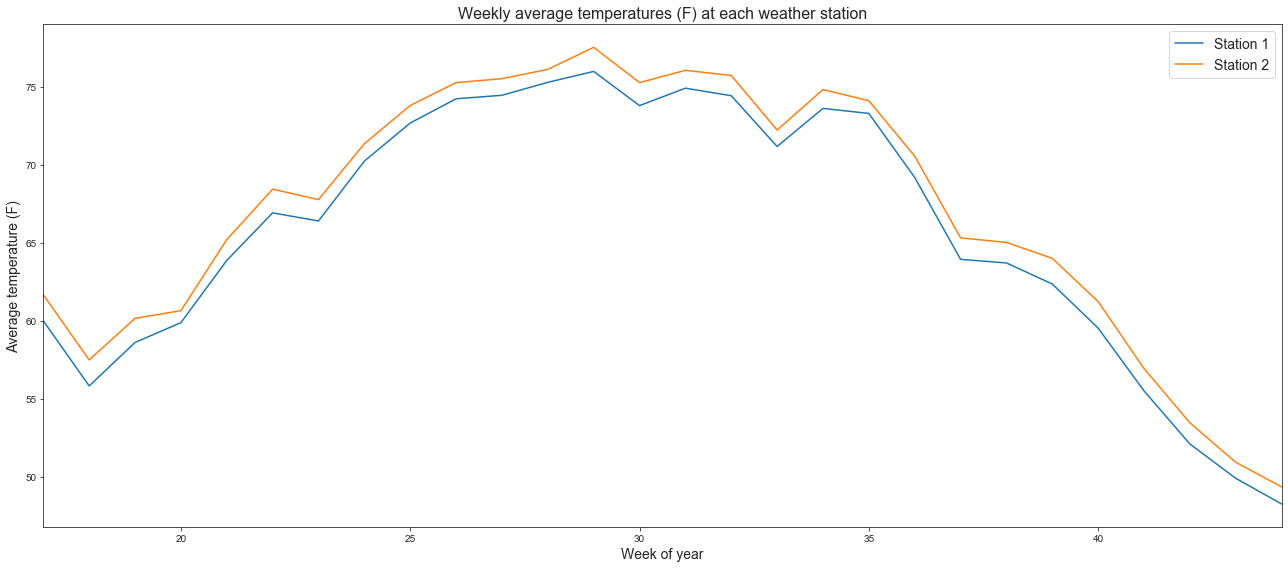

In [86]:
# plot weekly temperature by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==1], ci = None, label = "Station 1")
sns.lineplot(x = 'WeekofYear',y = 'Tavg', data = weather[weather.Station==2], ci = None, label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly average temperatures (F) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Average temperature (F)',fontsize=14)
plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

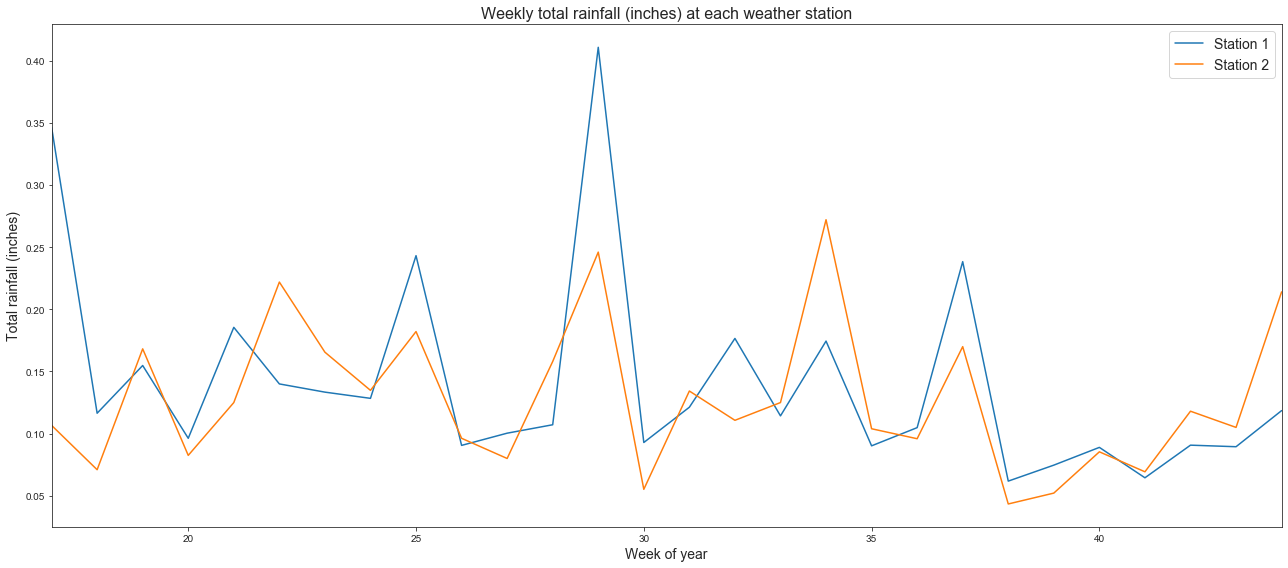

In [87]:
# plot weekly rainfall by station
plt.figure(figsize=(18,8))
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal',data = weather[weather.Station==1],ci = None,label = "Station 1")
sns.lineplot(x = 'WeekofYear',y = 'PrecipTotal',data = weather[weather.Station==2],ci = None,label = "Station 2")
plt.legend(fontsize = 14)
plt.title('Weekly total rainfall (inches) at each weather station', fontsize=16)
plt.xlabel('Week of year',fontsize=14)
plt.ylabel('Total rainfall (inches)',fontsize=14)
plt.xlim(weather.WeekofYear.min(), weather.WeekofYear.max())
plt.tight_layout()

From the graphs above, there are in fact discrepancies between the data captured which may likely be due to the difference in distance between the 2 stations. However, the discrepancies between the 2 weather stations seem to be insignificant visually especially from the graph showing the average temperature.

### Engineer some new features

**1. `Tavg` x (`PrecipTotal` + 1)**<br>
Temperature may have synergistic effects on the mosquito life cycle with precipitation. 1 is added to `PrecipTotal` to keep the `Tavg` value unchanged when `PrecipTotal` = 0 (i.e. no rain).

**2. Relative humidity**

**3. Temperature range**

**4. Delayed weather measurements**<br>
The average life cycle (eggs - adult) of a <i>Culex</i> mosquito is 14 days (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5654580/). Therefore, new columns will be created with the various weather columns being offset by 14 days.

In [88]:
weather['Date_Station'] = weather['Date'].astype(str) + '_' + weather['Station'].astype(str)

In [89]:
weather_sun = weather.loc[weather['Station'] == 1].copy()

weather_sun['Sunset'].unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [90]:
# Cleaning up wrong formatted of Sunset time

weather_sun['Sunset'] = weather_sun['Sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)


weather_sun['Sunrise_Time'] = weather_sun['Sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['Sunset_Time'] = weather_sun['Sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_sun['Daylight_Minutes'] = (weather_sun['Sunset_Time'] - weather_sun['Sunrise_Time']).map(lambda x : x.seconds / 60)


# Actually doesn't share that much correlation with average temperature, so may be we will want to add this in

weather_sun[['Daylight_Minutes', 'Tavg']].corr()


Daylight_Minutes      Tavg
Daylight_Minutes          1.000000  0.553301
Tavg                      0.553301  1.000000

In [91]:
weather = weather.merge(weather_sun[['Date', 'Daylight_Minutes']], on = 'Date')

In [92]:
# humidity
Tavg_C = ((weather['Tavg'] - 32) * 5 / 9)
DewPoint_C = ((weather['DewPoint'] - 32) * 5 / 9)
VapPress_Sat = np.exp((17.625 * Tavg_C) / (Tavg_C + 243.04))
VapPress_Act = np.exp((17.625 * DewPoint_C) / (DewPoint_C + 243.04))
R_Humidity = (VapPress_Act / VapPress_Sat) * 100

weather['R_Humid'] = R_Humidity

# temperature range
weather['Trange'] = weather['Tmax'] - weather['Tmin']

In [93]:
weather.head()

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50  66.5     14        51      56    0    2   
1        2 2007-05-01    84    52  68.0      M        51      57    0    3   
2        1 2007-05-02    59    42  50.5     -3        42      47   14    0   
3        2 2007-05-02    60    43  51.5      M        42      47   13    0   
4        1 2007-05-03    66    46  56.0      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  StnPressure  \
0    0448   1849             0      M      0.0          0.0        29.10   
1       -      -             M      M        M          0.0        29.18   
2    0447   1850      BR     0      M      0.0          0.0        29.38   
3       -      -   BR HZ     M      M        M          0.0        29.44   
4    0446   1851             0      M      0.0          0.0        29.39   

  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Month  WeekofYear  \
0    29.82          1.7         27       9.2  2007      5          18   
1    29.82          2.7         25       9.6  2007      5          18   
2    30.09         13.0          4      13.4  2007      5          18   
3    30.08         13.3          2      13.4  2007      5          18   
4    30.12         11.7          7      11.9  2007      5          18   

   Date_Station  Daylight_Minutes    R_Humid  Trange  
0  2007-05-01_1             841.0  57.422798      33  
1  2007-05-01_2             841.0  54.526426      32  
2  2007-05-02_1             843.0  72.526813      17  
3  2007-05-02_2             843.0  69.892062      17  
4  2007-05-03_1             845.0  54.874919      20

### Drop extra columns

In [94]:
# drop codesum as most of it is rain, which is captured in precip
weather.CodeSum.value_counts()

                   1609
RA                  296
RA BR               238
BR                  110
TSRA RA BR           92
                   ... 
TSRA FG+ BR           1
BR HZ VCFG            1
RA DZ FG+ FG BR       1
TSRA RA HZ FU         1
RA FG+ BR             1
Name: CodeSum, Length: 98, dtype: int64

In [95]:
## THINK NO NEED TO DROP?
## USING FUNCTION TO SLICE BELOw

# # drop unnecesary columns (including those that station 2 doesn't record)
# col_to_drop = ['Tmax','Tmin','ResultSpeed','ResultDir']
# weather.drop(col_to_drop, axis = 1,inplace=True)

### Univariate EDA

In [96]:
# combine data from the 2 weather stations
weather_combined = weather.groupby('Date').mean()
weather_combined.drop(['Station', 'Year','Month','WeekofYear'],axis=1,inplace=True)
weather_combined.reset_index(inplace=True)

In [97]:
# adding year/month/week columns back as they were previously affected by the groupby function and removed
weather_combined['year'] = weather_combined['Date'].apply(lambda x:x.year)
weather_combined['month'] = weather_combined['Date'].apply(lambda x:x.month)
weather_combined['weekofyear'] = weather_combined['Date'].apply(lambda x:x.weekofyear)

In [98]:
weather_combined.head()

Date  Tmax  Tmin   Tavg  DewPoint  PrecipTotal  StnPressure  \
0 2007-05-01  83.5  51.0  67.25      51.0          0.0       29.140   
1 2007-05-02  59.5  42.5  51.00      42.0          0.0       29.410   
2 2007-05-03  66.5  47.0  56.75      40.0          0.0       29.425   
3 2007-05-04  72.0  50.0  61.00      41.5          0.0       29.335   
4 2007-05-05  66.0  53.5  59.75      38.5          0.0       29.430   

   ResultSpeed  ResultDir  AvgSpeed  Daylight_Minutes    R_Humid  Trange  \
0         2.20       26.0      9.40             841.0  55.974612    32.5   
1        13.15        3.0     13.40             843.0  71.209437    17.0   
2        12.30        6.5     12.55             845.0  53.429105    19.5   
3        10.25        7.5     10.60             848.0  48.932050    22.0   
4        11.45        7.0     11.75             850.0  45.237980    12.5   

   year  month  weekofyear  
0  2007      5          18  
1  2007      5          18  
2  2007      5          18  
3  2007      5          18  
4  2007      5          18

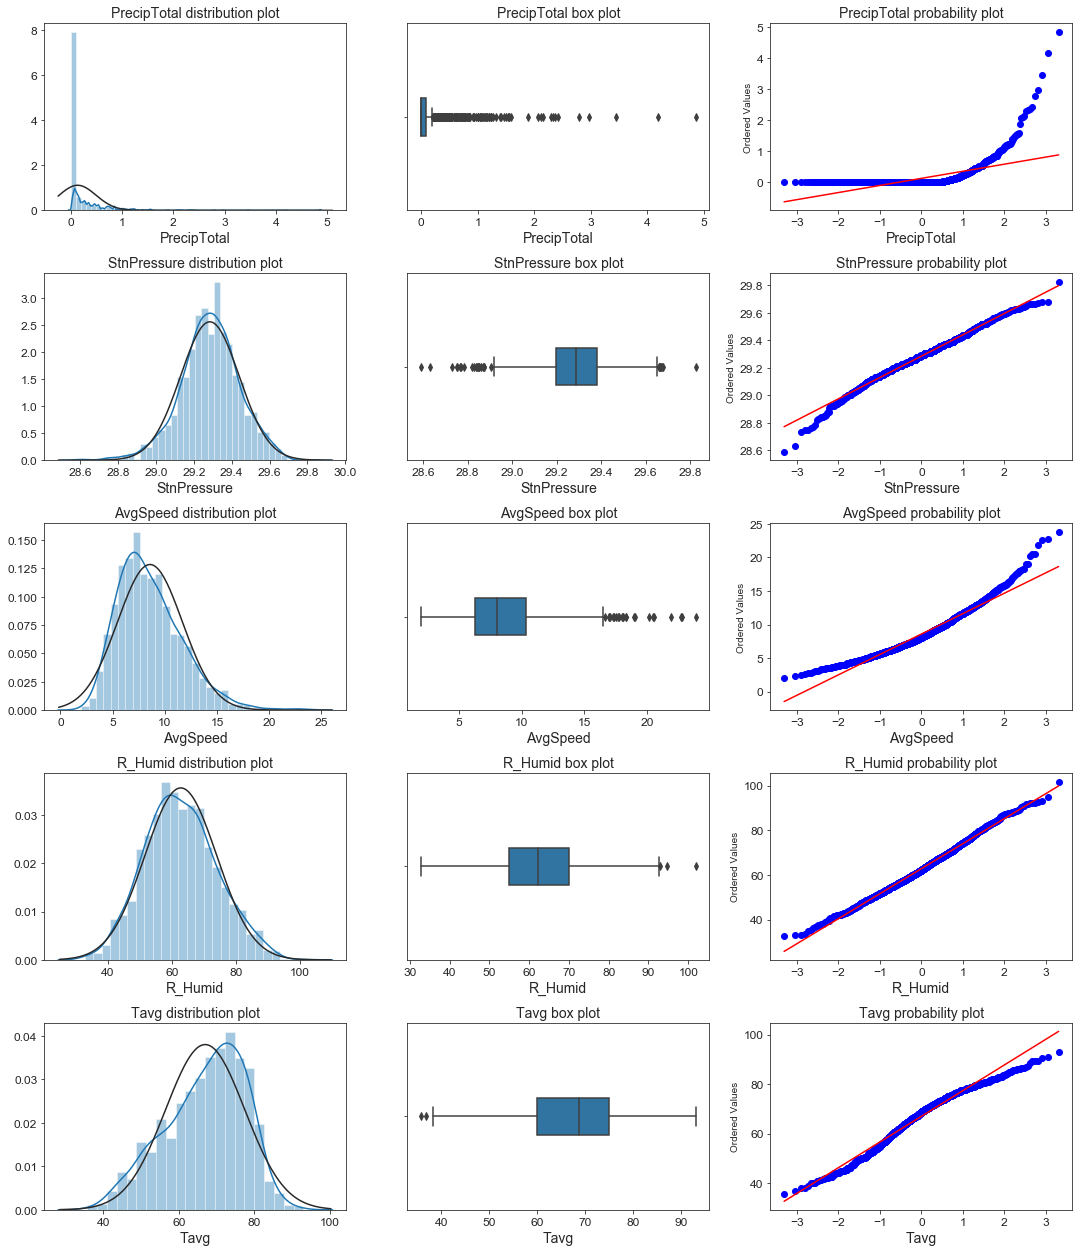

In [99]:
dist_plots(weather_combined,['Tavg', 'PrecipTotal', 'StnPressure', 'AvgSpeed', 'R_Humid',])

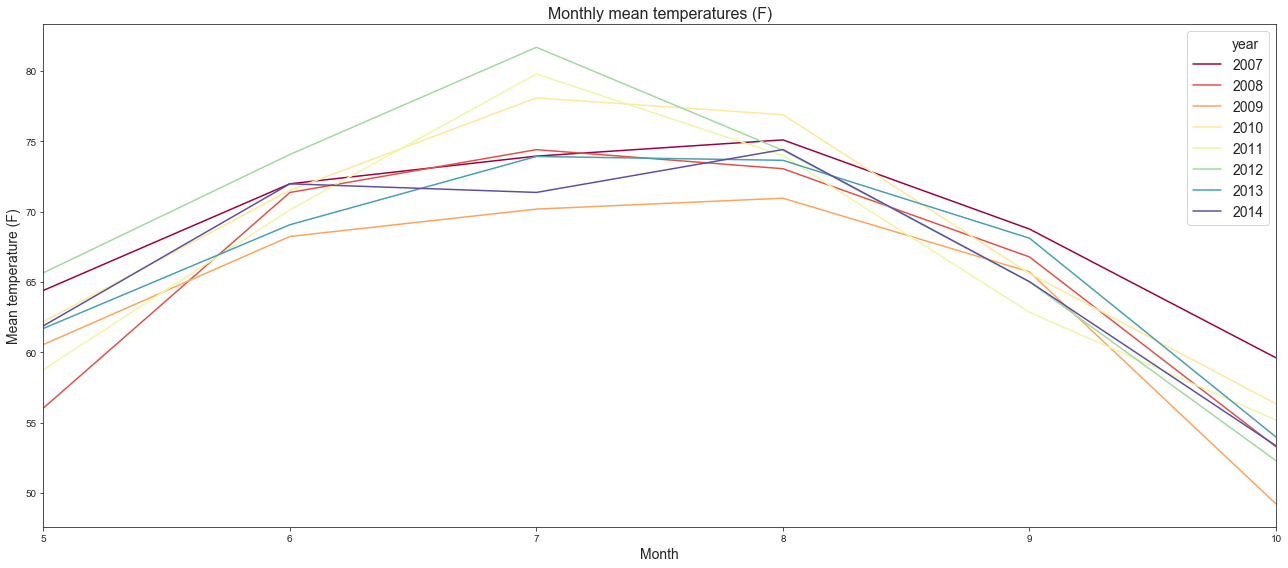

In [100]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'Tavg', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

Generally, the temperature cycle climbs from May to August and peak in July (with the exception of 2007 and 2014 where the peak is in August) before starting to decrease from August.

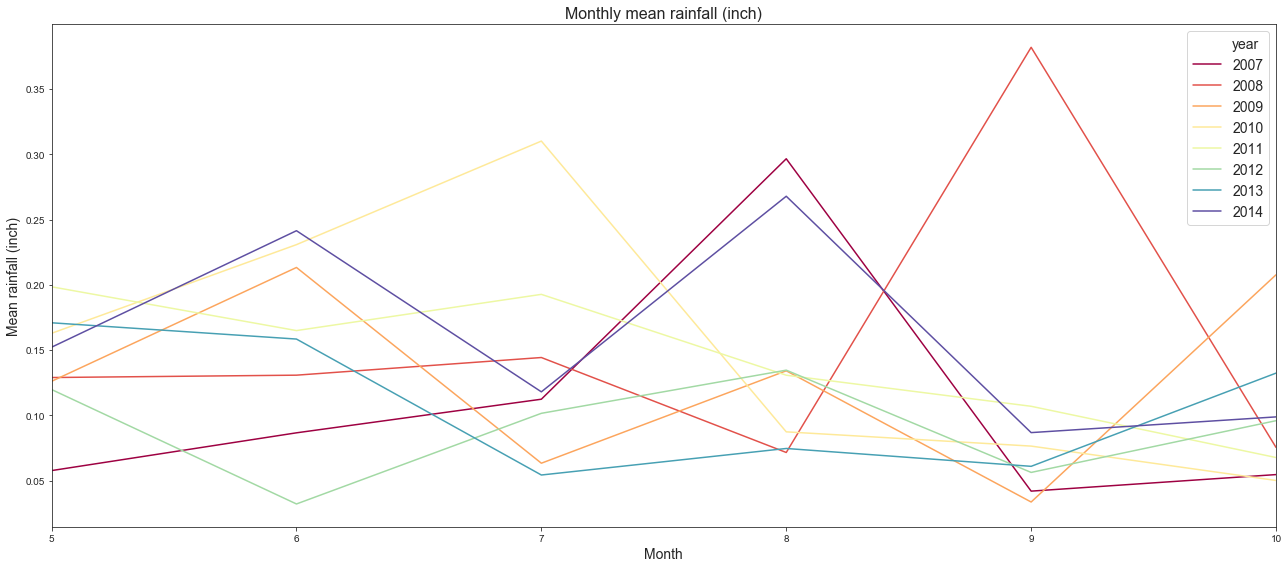

In [101]:
# plot rainfall by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'PrecipTotal', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean rainfall (inch)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean rainfall (inch)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

There is no distinct pattern in the average amount of rainfall as it varies from year to year. However, it does look have an exceptionally high amount of average rainfall in September 2008.

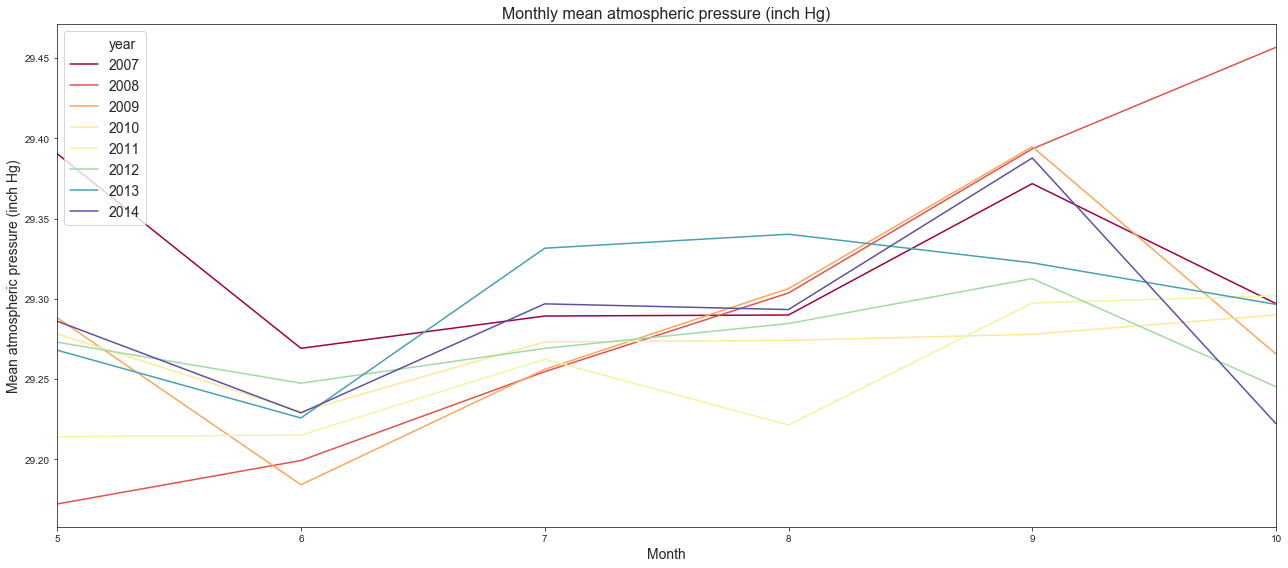

In [102]:
# plot atmospheric pressure by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'StnPressure', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean atmospheric pressure (inch Hg)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean atmospheric pressure (inch Hg)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

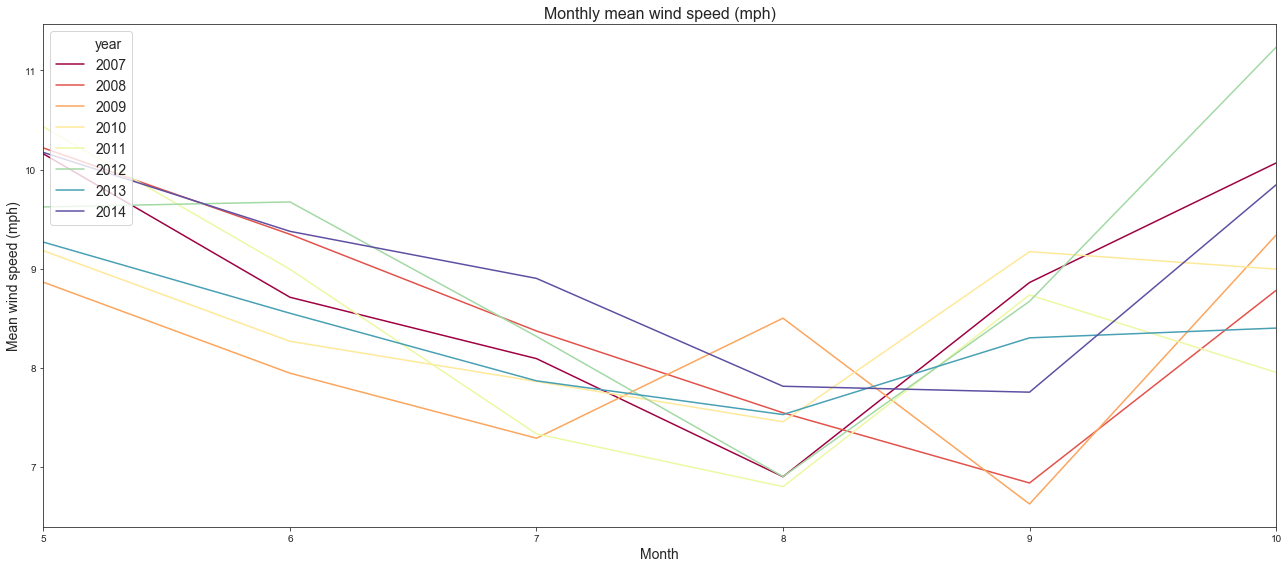

In [103]:
# plot wind speed by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'AvgSpeed', data = weather_combined, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(loc = 'upper left', fontsize = 14)
plt.title('Monthly mean wind speed (mph)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean wind speed (mph)',fontsize=14)
plt.xlim(weather_combined.month.min(), weather_combined.month.max())
plt.tight_layout()

### Bivariate EDA

#### Combine weather + traps

In [104]:
trap.head()

Date                                           Address  \
0  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1  2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2  2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3  2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4  2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Year  Month  WeekofYear YearMonth  NumMosquitos  WnvPresent  \
0  2007      5          22   2007-05             1           0   
1  2007      5          22   2007-05             2           0   
2  2007      5          22   2007-05             1           0   
3  2007      5          22   2007-05             1           0   
4  2007      5          22   2007-05             1           0   

                     Coord  Cluster                    geometry  Day  Week  \
0  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22   
1  (41.867108, -87.654224)        4  POINT (-87.65422 41.86711)   29    22   
2   (41.862292, -87.64886)        4  POINT (-87.64886 41.86229)   29    22   
3  (41.896282, -87.655232)        5  POINT (-87.65523 41.89628)   29    22   
4  (41.907645, -87.760886)        7  POINT (-87.76089 41.90765)   29    22   

  n3_intersect_dates n3_spray_sets n3_spray_geom n3_spray_coord  \
0               None          None          None           None   
1               None          None          None           None   
2               None          None          None           None   
3               None          None          None           None   
4               None          None          None           None   

  n3_spray_dist_deg n3_spray_dist_m  
0              None            None  
1              None            None  
2              None            None  
3              None            None  
4              None            None

In [105]:
station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
trap['Nearest_Station'] = trap['geometry'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)

trap['Date_Station'] = trap['Date'].astype(str) + '_' + trap['Nearest_Station'].astype(str)


In [106]:
weather.head()

Station       Date  Tmax  Tmin  Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1 2007-05-01    83    50  66.5     14        51      56    0    2   
1        2 2007-05-01    84    52  68.0      M        51      57    0    3   
2        1 2007-05-02    59    42  50.5     -3        42      47   14    0   
3        2 2007-05-02    60    43  51.5      M        42      47   13    0   
4        1 2007-05-03    66    46  56.0      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  StnPressure  \
0    0448   1849             0      M      0.0          0.0        29.10   
1       -      -             M      M        M          0.0        29.18   
2    0447   1850      BR     0      M      0.0          0.0        29.38   
3       -      -   BR HZ     M      M        M          0.0        29.44   
4    0446   1851             0      M      0.0          0.0        29.39   

  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Year  Month  WeekofYear  \
0    29.82          1.7         27       9.2  2007      5          18   
1    29.82          2.7         25       9.6  2007      5          18   
2    30.09         13.0          4      13.4  2007      5          18   
3    30.08         13.3          2      13.4  2007      5          18   
4    30.12         11.7          7      11.9  2007      5          18   

   Date_Station  Daylight_Minutes    R_Humid  Trange  
0  2007-05-01_1             841.0  57.422798      33  
1  2007-05-01_2             841.0  54.526426      32  
2  2007-05-02_1             843.0  72.526813      17  
3  2007-05-02_2             843.0  69.892062      17  
4  2007-05-03_1             845.0  54.874919      20

In [107]:
#weather.drop(['Date', 'year','month','weekofyear'], axis=1, inplace=True)
combined = pd.merge(trap.drop(columns = 'Date'), weather.drop(columns = ['Date', 'Year','Month',\
                                                                         'WeekofYear']), how = 'left', \
                                                              left_on = 'Date_Station', \
                                                              right_on = 'Date_Station')
combined.head()

Address                 Species  \
0       1100 Roosevelt Road, Chicago, IL 60608, USA  CULEX PIPIENS/RESTUANS   
1       1100 Roosevelt Road, Chicago, IL 60608, USA          CULEX RESTUANS   
2  1100 South Peoria Street, Chicago, IL 60608, USA          CULEX RESTUANS   
3  1100 West Chicago Avenue, Chicago, IL 60642, USA          CULEX RESTUANS   
4    1500 North Long Avenue, Chicago, IL 60651, USA          CULEX RESTUANS   

   Block        Street  Trap          AddressNumberAndStreet   Latitude  \
0     11   W ROOSEVELT  T048  1100  W ROOSEVELT, Chicago, IL  41.867108   
1     11   W ROOSEVELT  T048  1100  W ROOSEVELT, Chicago, IL  41.867108   
2     11   S PEORIA ST  T091  1100  S PEORIA ST, Chicago, IL  41.862292   
3     11     W CHICAGO  T049    1100  W CHICAGO, Chicago, IL  41.896282   
4     15    N LONG AVE  T153   1500  N LONG AVE, Chicago, IL  41.907645   

   Longitude  AddressAccuracy  Year  Month  WeekofYear YearMonth  \
0 -87.654224                8  2007      5          22   2007-05   
1 -87.654224                8  2007      5          22   2007-05   
2 -87.648860                8  2007      5          22   2007-05   
3 -87.655232                8  2007      5          22   2007-05   
4 -87.760886                8  2007      5          22   2007-05   

   NumMosquitos  WnvPresent                    Coord  Cluster  \
0             1           0  (41.867108, -87.654224)        4   
1             2           0  (41.867108, -87.654224)        4   
2             1           0   (41.862292, -87.64886)        4   
3             1           0  (41.896282, -87.655232)        5   
4             1           0  (41.907645, -87.760886)        7   

                     geometry  Day  Week n3_intersect_dates n3_spray_sets  \
0  POINT (-87.65422 41.86711)   29    22               None          None   
1  POINT (-87.65422 41.86711)   29    22               None          None   
2  POINT (-87.64886 41.86229)   29    22               None          None   
3  POINT (-87.65523 41.89628)   29    22               None          None   
4  POINT (-87.76089 41.90765)   29    22               None          None   

  n3_spray_geom n3_spray_coord n3_spray_dist_deg n3_spray_dist_m  \
0          None           None              None            None   
1          None           None              None            None   
2          None           None              None            None   
3          None           None              None            None   
4          None           None              None            None   

   Nearest_Station  Date_Station  Station  Tmax  Tmin  Tavg Depart  DewPoint  \
0                2  2007-05-29_2        2    88    65  76.5      M        59   
1                2  2007-05-29_2        2    88    65  76.5      M        59   
2                2  2007-05-29_2        2    88    65  76.5      M        59   
3                2  2007-05-29_2        2    88    65  76.5      M        59   
4                2  2007-05-29_2        2    88    65  76.5      M        59   

  WetBulb Heat Cool Sunrise Sunset CodeSum Depth Water1 SnowFall  PrecipTotal  \
0      66    0   12       -      -   BR HZ     M      M        M          0.0   
1      66    0   12       -      -   BR HZ     M      M        M          0.0   
2      66    0   12       -      -   BR HZ     M      M        M          0.0   
3      66    0   12       -      -   BR HZ     M      M        M          0.0   
4      66    0   12       -      -   BR HZ     M      M        M          0.0   

   StnPressure SeaLevel  ResultSpeed  ResultDir  AvgSpeed  Daylight_Minutes  \
0        29.44    30.09          5.8         16       7.4             896.0   
1        29.44    30.09          5.8         16       7.4             896.0   
2        29.44    30.09          5.8         16       7.4             896.0   
3        29.44    30.09          5.8         16       7.4             896.0   
4        29.44    30.09          5.8         16       7.4             896.0   

   

#### Pairplot

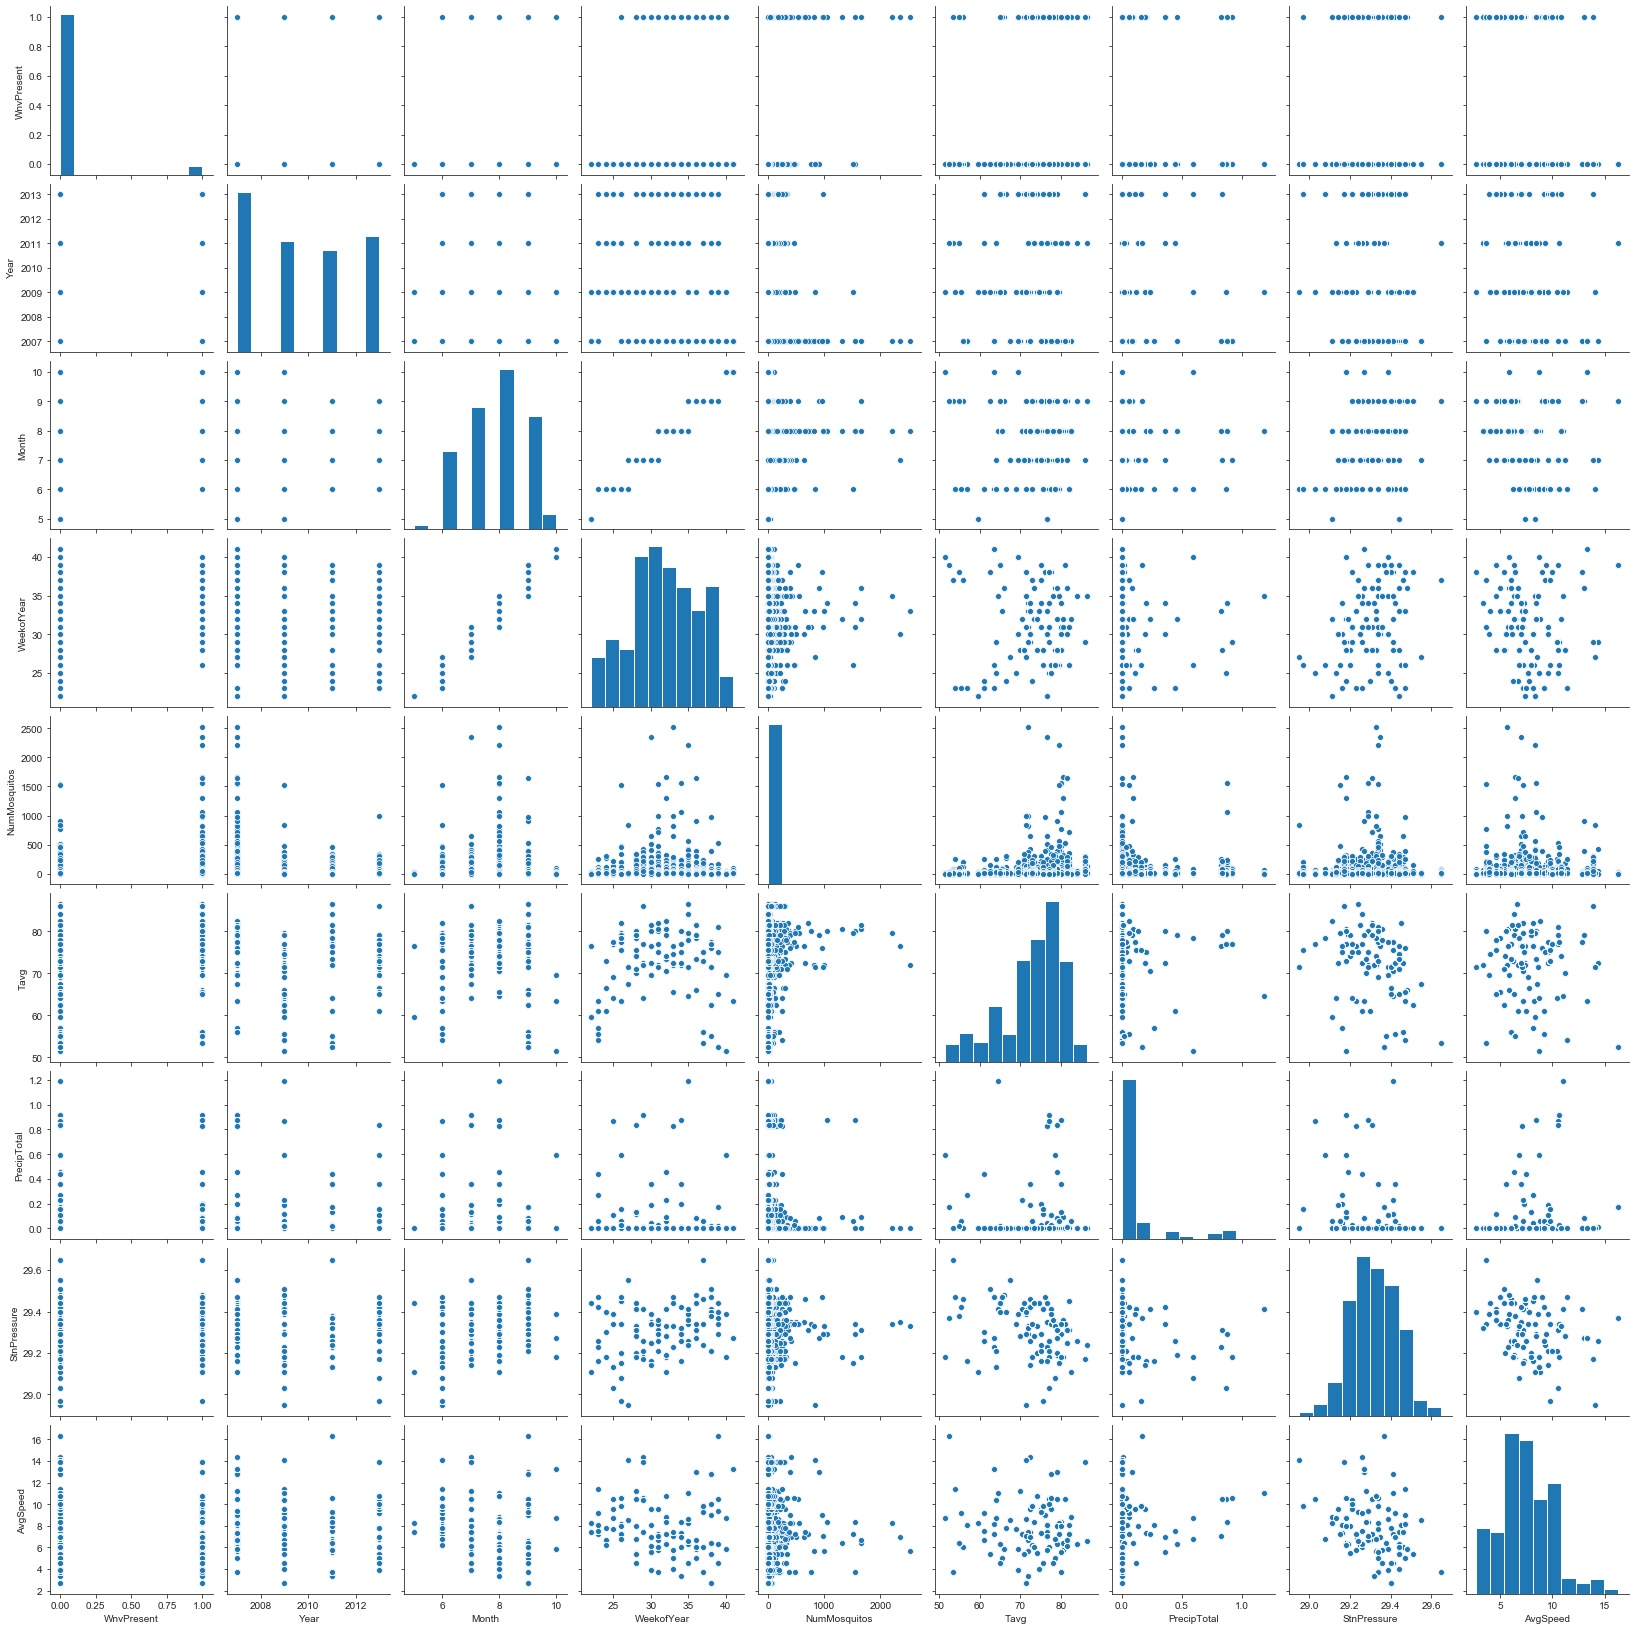

In [108]:
sns.pairplot(combined[['WnvPresent','Year','Month','WeekofYear','NumMosquitos','Tavg',\
                       'PrecipTotal','StnPressure','AvgSpeed']])

#### Correlation heatmap

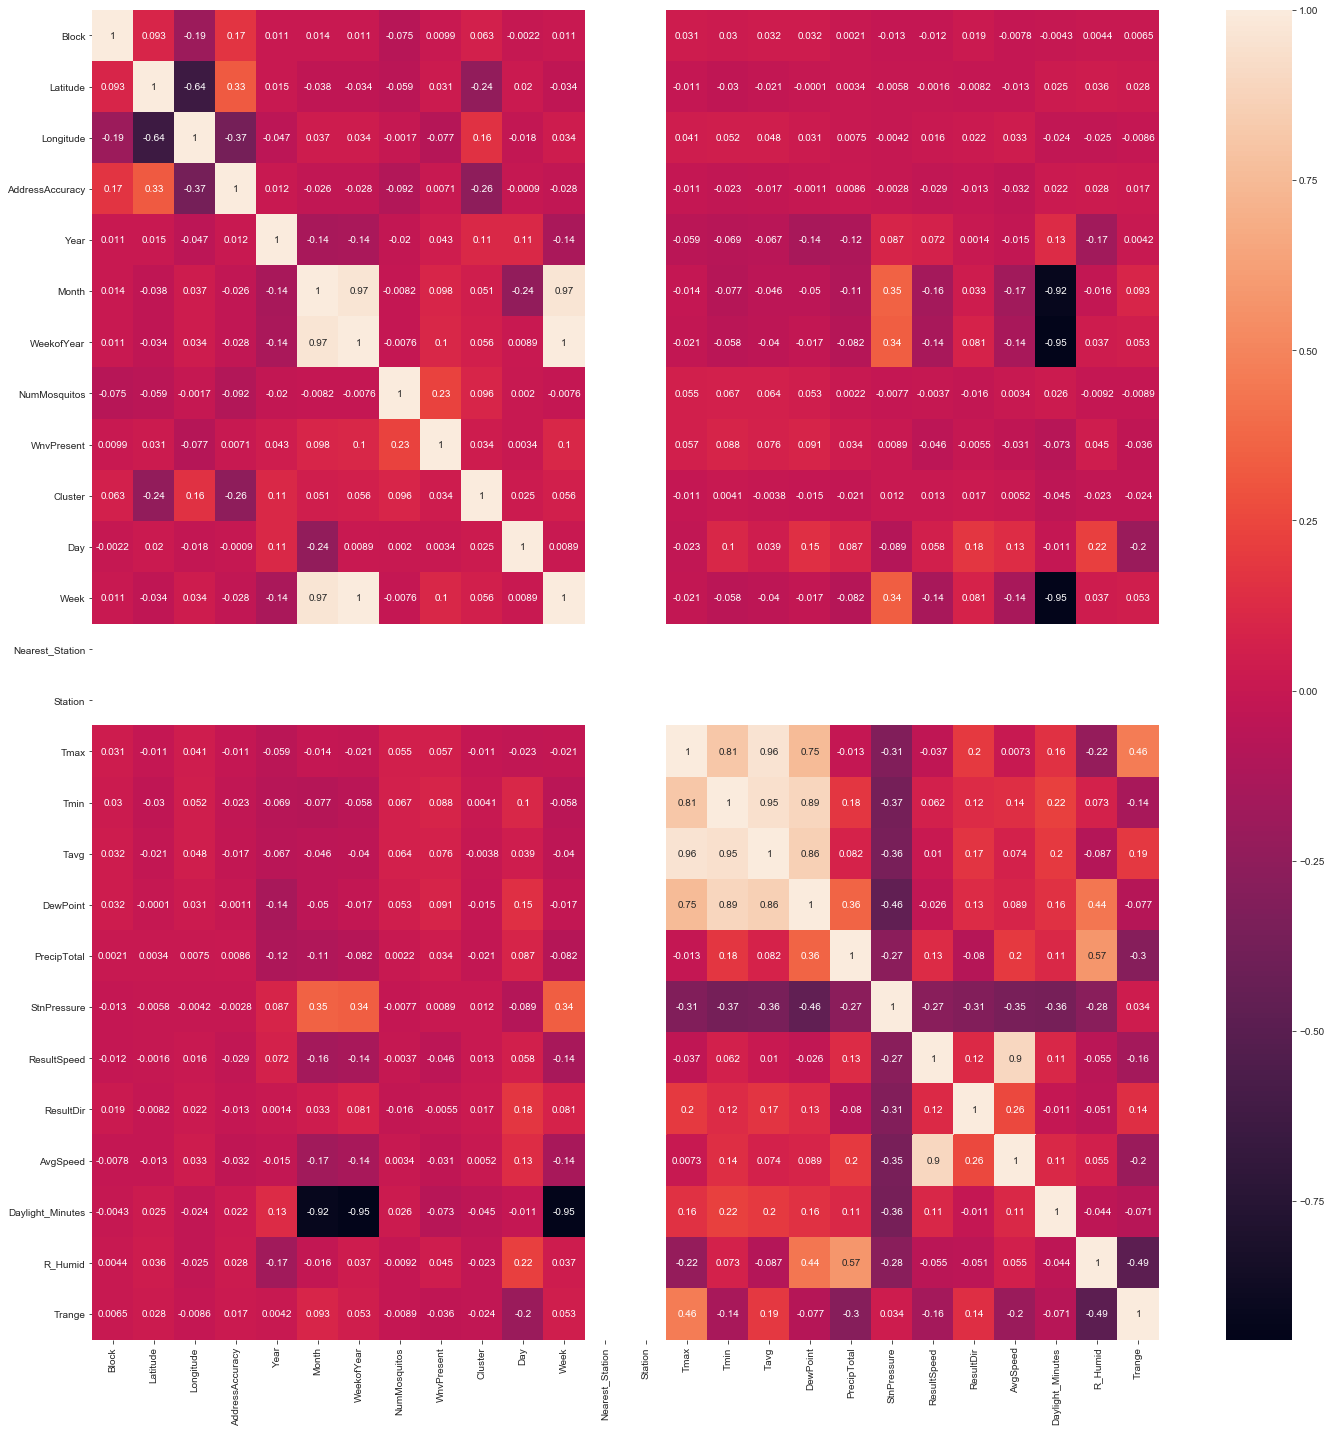

In [109]:
plt.figure(figsize=(20,20))
sns.heatmap(combined.corr(), annot = True)
plt.tight_layout()

From the pairplot and heatmap, there are no obvious correlation probably due to the nature of an imbalance dataset.

#### Map

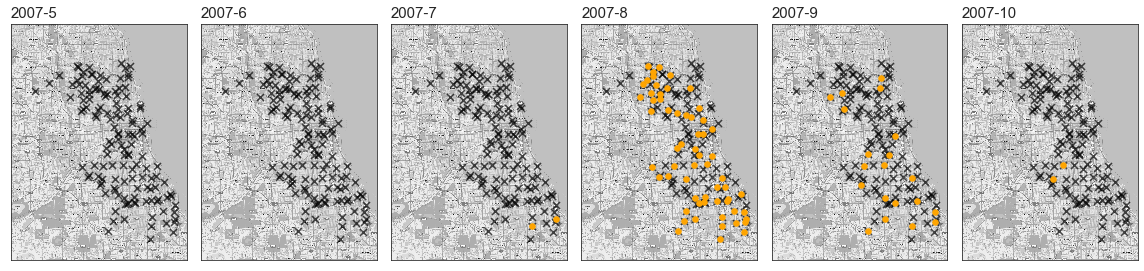

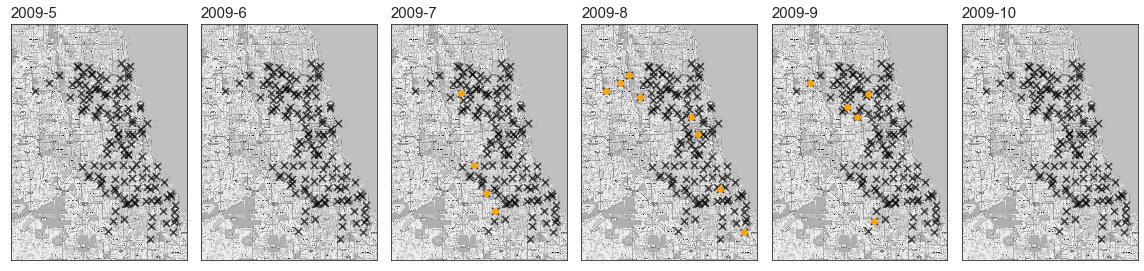

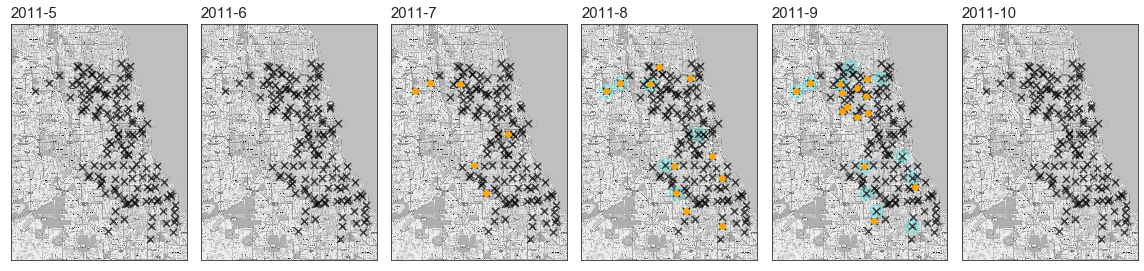

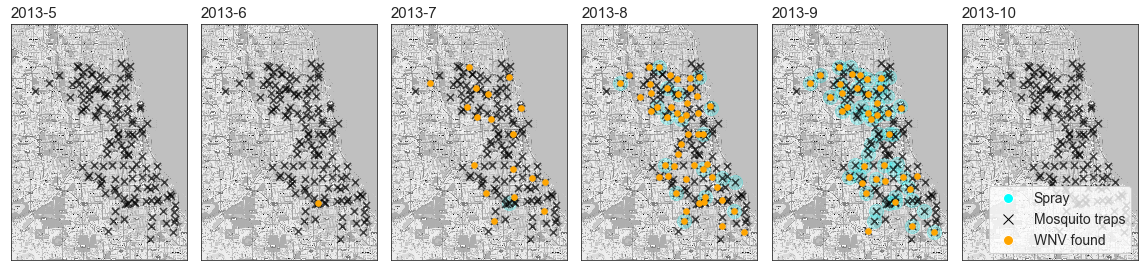

In [110]:
# plot spray data
spray1['year'] = spray1.Date.apply(lambda x:x.year)
spray1['month'] = spray1.Date.apply(lambda x:x.month)

# set up basemap
mapdata = np.loadtxt("assets/mapdata_copyright_openstreetmap_contributors.txt")
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# create plot for each month and year 
for year in combined.Year.unique():
    fig, ax = plt.subplots(ncols = 6, figsize = (16,5))
    
    for i, month in enumerate([5,6,7,8,9,10]):
        # plot basemap
        ax[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
        
        # plot spray locations for year and month
        if year in spray1.year.unique() and month in spray1.month.unique():
            sprayed = spray1[(spray1.year == year) & (spray1.month == month)][['Longitude', 'Latitude']].drop_duplicates().values
            ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'cyan', s = 200, alpha = 0.2)
        
        # plot trap locations
        locations = combined[['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(locations[:,0], locations[:,1], marker='x', c = 'black', s=50, alpha = 0.7)
        
        # plot wnv locations for year and month
        wnv = combined[(combined.Year == year) & (combined.Month == month) & (combined.WnvPresent == 1)]\
                [['Longitude', 'Latitude']].drop_duplicates().values
        ax[i].scatter(wnv[:,0], wnv[:,1], marker='o', c = 'orange', s = 30)
        
        # title and axes
        ax[i].set_title(f"{year}-{month}", fontsize = 15, ha = 'left', position = (0,1))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
        plt.tight_layout()
#         plt.savefig(f'heatmap_{year}_{month}')

# custom legend
legend_elements=[Line2D([0],[0],marker='o', color='w',label='Spray', markerfacecolor='cyan', markersize=10),
                 Line2D([0],[0],marker='x', color='black', label='Mosquito traps',linestyle='', markersize=10),
                 Line2D([0],[0],marker='o', color='w',label='WNV found',markerfacecolor='orange', markersize=10)]

plt.legend(handles=legend_elements, loc='lower right', fontsize=14)
plt.tight_layout()

From the map above, it is clear that the presence of WNV almost always increase from July and peak in the month of August where the temperature is 68 to 75 degrees Fahrenheit. From our research, mosquitoes seem to breed faster but also die faster at a higher temperature. Although, we do not have the upper and lower limit of the temperature where it stops affecting the life cycle of mosquitoes, there isn't much discrepancy in the temperature year over year.

To our surprise, wind speed does seem to affect the number of WNV present with the exception of August 2009, the mean monthly wind speed are usually low in August.

# Preprocessing

In [111]:
def weather_moving_average(df, cols_mean, cols_sum, start, end):
    
    suffix = ''.join(['_', str(start), '_', str(end)])
   
    stations = df['Station'].unique()
    
    cols_mean_name = [cols + '_mean' + suffix for cols in cols_mean]
    cols_sum_name = [cols + '_sum' + suffix for cols in cols_sum]
    
    new_cols = []
    new_cols.extend(cols_mean_name)
    new_cols.extend(cols_sum_name)
    new_cols.extend(['Date_Station'])
      
    df_rolling = pd.DataFrame(None, columns = new_cols)
    
    for station in stations:
        station_mean = df.loc[(df['Station'] == station), cols_mean].rolling(end - start).mean().shift(start)
        station_mean.columns = cols_mean_name
        
        station_sum = df.loc[(df['Station'] == station), cols_sum].rolling(end - start).sum().shift(start)
        station_sum.columns = cols_sum_name
        
        df_station = pd.concat([station_mean, station_sum], axis = 1)
        df_station['Date_Station'] = df.loc[(df['Station'] == station), 'Date_Station']
        
        df_rolling = df_rolling.append(df_station)
            
    return df_rolling


In [112]:
# define preprocessing function

def preprocess_train(trap_df, trap_cols_copy, trap_cols_dummy, weather_df, cols_mean, cols_sum, start, end, cluster_map):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    
    df_preprocess = trap_df.copy()
    
    # datetime
    df_preprocess['Year'] = df_preprocess['Date'].apply(lambda x:x.year)
    df_preprocess['Month'] = df_preprocess['Date'].apply(lambda x:x.month)
    df_preprocess['YearMonth'] = df_preprocess['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    df_preprocess['WeekofYear'] = df_preprocess['Date'].apply(lambda x:x.weekofyear)
    df_preprocess['DayofYear'] = df_preprocess['Date'].apply(lambda x:x.dayofyear)

    # locations
    df_preprocess['LatLong'] = [(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    df_preprocess['Coord'] = [Point(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
    df_preprocess['Nearest_Station'] = df_preprocess['Coord'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)
    df_preprocess['Date_Station'] = df_preprocess['Date'].astype(str) + '_' + df_preprocess['Nearest_Station'].astype(str)
    
    # combine with weather
    df_weather_roll = weather_moving_average(weather_df, cols_mean, cols_sum, start, end)
    
    preprocess_cols = trap_cols_copy.copy()
    preprocess_cols.extend(trap_cols_dummy)
    preprocess_cols.extend(['Date_Station', 'LatLong', 'WnvPresent'])
    df_preprocess = df_preprocess[preprocess_cols]

    if cluster_map != None:
        df_preprocess['Cluster'] = df_preprocess['LatLong'].map(cluster_map)
        df_preprocess = pd.get_dummies(df_preprocess, columns = ['Cluster'])
        
    df_preprocess = pd.get_dummies(df_preprocess, columns = trap_cols_dummy)
    
    df_preprocess = df_preprocess.merge(df_weather_roll, on = 'Date_Station').drop(columns = 'Date_Station')
    
    if 'LatLong' not in trap_cols_copy and 'LatLong' not in trap_cols_dummy:
        df_preprocess = df_preprocess.drop(columns = 'LatLong')
    
    return df_preprocess



In [113]:
# define preprocessing function

def preprocess_test(test_df, preprocess_train, trap_cols_copy, trap_cols_dummy, weather_df, cols_mean, \
                    cols_sum, start, end, cluster_map, trap_df):
    
    # ---------------------------------- MAKE NEW COLUMNS -------------------------------------
    
    df_preprocess = test_df.copy()
    
    # datetime
    df_preprocess['Year'] = df_preprocess['Date'].apply(lambda x:x.year)
    df_preprocess['Month'] = df_preprocess['Date'].apply(lambda x:x.month)
    df_preprocess['YearMonth'] = df_preprocess['Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
    df_preprocess['WeekofYear'] = df_preprocess['Date'].apply(lambda x:x.weekofyear)
    df_preprocess['DayofYear'] = df_preprocess['Date'].apply(lambda x:x.dayofyear)

    # locations
    df_preprocess['LatLong'] = [(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    df_preprocess['Coord'] = [Point(x, y) for x, y in zip(df_preprocess['Latitude'], df_preprocess['Longitude'])]
    
    
    # ---------------------------------- JOIN WITH WEATHER -------------------------------------
    station_points = MultiPoint([Point(41.995, -87.933), Point(41.786, -87.752)])
    df_preprocess['Nearest_Station'] = df_preprocess['Coord'].map(lambda x : 1 if nearest_points(station_points, x)[0] == station_points[0] else 2)
    df_preprocess['Date_Station'] = df_preprocess['Date'].astype(str) + '_' + df_preprocess['Nearest_Station'].astype(str)
    
    # combine with weather
    df_weather_roll = weather_moving_average(weather_df, cols_mean, cols_sum, start, end)
    
    preprocess_cols = trap_cols_copy.copy()
    preprocess_cols.extend(trap_cols_dummy)
    preprocess_cols.extend(['Date_Station', 'LatLong'])
    df_preprocess = df_preprocess[preprocess_cols]
    
    if cluster_map != None:
        knn = KNeighborsClassifier(n_neighbors = 1)
        trap_df['LatLong'] = [(x, y) for x, y in zip(trap_df['Latitude'], trap_df['Longitude'])]
        trap_df['Cluster'] = trap_df['LatLong'].map(cluster_map)
        knn.fit(trap_df[['Latitude', 'Longitude']], trap_df['Cluster'])
        df_preprocess[['Latitude', 'Longitude']] = test_df[['Latitude', 'Longitude']]
        df_preprocess['Cluster'] = knn.predict(df_preprocess[['Latitude', 'Longitude']])
        df_preprocess = pd.get_dummies(df_preprocess, columns = ['Cluster'])

        if 'Latitude' not in trap_cols_copy and 'Latitude' not in trap_cols_dummy:
            df_preprocess = df_preprocess.drop(columns = 'Latitude')
        if 'Longitude' not in trap_cols_copy and 'Longitude' not in trap_cols_dummy:
            df_preprocess = df_preprocess.drop(columns = 'Longitude')
        
    df_preprocess = pd.get_dummies(df_preprocess, columns = trap_cols_dummy)
    
    df_preprocess = df_preprocess.merge(df_weather_roll, on = 'Date_Station').drop(columns = 'Date_Station')
    


    if 'LatLong' not in trap_cols_copy and 'LatLong' not in trap_cols_dummy:
        df_preprocess = df_preprocess.drop(columns = 'LatLong')
        
    
    preprocess_train, df_preprocess = preprocess_train.align(df_preprocess, join = 'outer', fill_value = 0, axis = 1)
    
    return preprocess_train, df_preprocess



In [114]:
roll_dict = {
    1 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 10],
    2 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 14],
    3 : [['WeekofYear', 'DayofYear', 'Month', 'Latitude', 'Longitude'], ['Species'], \
         ['Tavg', 'Trange', 'DewPoint', 'StnPressure', 'AvgSpeed', 'R_Humid'], ['PrecipTotal', 'Daylight_Minutes'], \
         0, 18],
}


df_dict = {}

df_dict_names = {
    1 : 'Rolling 10 days',
    2 : 'Rolling 14 days',
    3 : 'Rolling 18 days'
}



In [115]:
# process train data
trap_pre = pd.read_csv('assets/train.csv', parse_dates=['Date'])
test_pre = pd.read_csv('assets/test.csv', index_col=0, parse_dates =['Date'])

for i in roll_dict.keys():
    df_dict[i] = {}
    df_dict[i]['name'] = df_dict_names[i]
    df_dict[i]['train'] = preprocess_train(trap_pre.copy(), roll_dict[i][0], roll_dict[i][1], weather, \
                                           roll_dict[i][2], roll_dict[i][3], roll_dict[i][4], roll_dict[i][5], \
                                           cluster_dict)
    df_dict[i]['train'], df_dict[i]['test'] = preprocess_test(test_pre.copy(), df_dict[i]['train'].copy(), roll_dict[i][0], \
                                                              roll_dict[i][1], weather, roll_dict[i][2], roll_dict[i][3], \
                                                              roll_dict[i][4], roll_dict[i][5], cluster_dict, \
                                                              trap_pre.copy())


In [116]:
# process test data

df_processed = pd.DataFrame(df_dict)
df_processed.to_pickle('assets/processed.zip')